# DS for Business Project 2 - Marketing Department

This version of the notebook will demonstrate the use of the "Refined" Clustering model that will output customer data into separate clusters/groups. These clusters will be based on their credit card behaviour over 6 months. The goal is to aid the marketing department's efforts in building a targeted marketing campaign. This notebook aims to cut out all the step-by-step procedure to achieving the end result that was previously experimented in the "DSB_Marketing Department.ipynb" file. 

Required Files to run this project/demonstration:
- AutoEncoder_model
- kMeans_cluster_and_evaluation.py
- Preprocessing_Utilities.py

## Introduction:

In every business, an effective Marketing department plays a crucial role in developing the company's growth and sustainability. The department is able to build the company's brand and engage customers leading towards increased sales for greater revenue growth.

The diagram below summarises the key roles of Marketing:

<img src="Description Images/role_of_marketing.jpg" width="350">

Image Ref -> https://courses.lumenlearning.com/wmopen-introbusiness/chapter/the-role-of-customers-in-marketing/

In this project, the goal is to tackle the challenge of launching a __targeted marketing campaign__ and this campaign will be based on 6 months worth of customer data (description below). To do this, marketers are required to understand their customers, their behaviours and drive, so that their needs can be identified. Having developed an understanding of their needs, the marketing campaign can be specifically tailored to each of the individual customer's needs. This should drive up sales for the company's products (may even discover new opportunities). The availability of customer data can provide data scientists the opportunity to perform __Market Segmentation or rather Customer Segmentation__. This means that, based on the customer's behaviour and needs, they can be grouped separately for different marketing purposes, where the main question to be answered is: __How many distinctive groups can be found for the data to streamline the campaign?__


## Breakdown of this Project:
1. Loading in the Dataset.
2. Exploratory Data Analysis (Visualise the data).
3. Examining the Outliers.
4. Dataset preparation (Data cleaning, training and testing splits)
5. K-Means Clustering Techniques with all the data
6. Visualise the Customer Groups/Segmentation with PCA and t-SNE.
7. Refine the number of clusters with AutoEncoders.
8. Visualise the refined Customer Groups/Segmentation with PCA and t-SNE.
9. Model Comparison, Evaluation and Conclusion (Marketing strategy suggestion).

## Dataset:

Link: https://www.kaggle.com/arjunbhasin2013/ccdata

As quoted from the link, the description is:

This case requires to develop a customer segmentation to define marketing strategy. The
sample Dataset summarizes the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables.

The following shows the attributes of the Credit Card dataset :

- __CUSTID__ : Identification of Credit Card holder (Categorical) 
- __BALANCE__ : Balance amount left in their account to make purchases 
- __BALANCEFREQUENCY__ : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated) 
- __PURCHASES__ : Amount of purchases made from account 
- __ONEOFFPURCHASES__ : Maximum purchase amount done in one-go 
- __INSTALLMENTSPURCHASES__ : Amount of purchase done in installment 
- __CASHADVANCE__ : Cash in advance given by the user 
- __PURCHASESFREQUENCY__ : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased) 
- __ONEOFFPURCHASESFREQUENCY__ : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased) 
- __PURCHASESINSTALLMENTSFREQUENCY__ : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done) 
- __CASHADVANCEFREQUENCY__ : How frequently the cash in advance being paid 
- __CASHADVANCETRX__ : Number of Transactions made with "Cash in Advanced" 
- __PURCHASESTRX__ : Number of purchase transactions made 
- __CREDITLIMIT__ : Limit of Credit Card for user 
- __PAYMENTS__ : Amount of Payment done by user 
- __MINIMUM_PAYMENTS__ : Minimum amount of payments made by user 
- __PRCFULLPAYMENT__ : Percent of full payment paid by user 
- __TENURE__ : Tenure of credit card service for user 

## Requirements:
- Numpy
- Pandas
- Seaborn
- Matplotlib
- scikit-learn (sklearn)
- os
- timeit
- tensorflow (or Keras)
- scipy

## 1 - Setting up the Libraries:

In [1]:
import os
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.initializers import glorot_uniform
from scipy.stats import zscore

from Preprocessing_Utilities import *
from kMeans_cluster_and_evaluation import *
from AutoEncoder_model import *

# Run on GPU:
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 

## 1.1 - Setup the Criteria for this Clustering Model:

Choice on the clustering set up: 
- if __Criteria = 0__ , it means that clustering model will produce the lowest number of clusters possible (e.g. 3 to 4 clusters). 
- if __Criteria = 1__ , it means that clustering model will produce the higher number of clusters possible (e.g. more than 6 clusters). 

In [2]:
criteria = 1

## 2 - Load in the Dataset:


In [3]:
# Dataset Filename:
dataset_fileName = 'Marketing_data.csv'

# Set up the Working Directory:
currentDirectory = os.getcwd()
path_to_dataset = currentDirectory + '/Dataset/' + dataset_fileName

In [4]:
# Load in the File: .csv format
marketing_data_df = pd.read_csv(path_to_dataset)

## 3 - Clean and Preprocess the Dataset in Pipeline:

Here, the pre-processing steps defined above will be set up in a pipeline to process and transform the dataset to be ready for K-Means Clustering.

The sequence of the Pipeline:
1. Deal with the missing vlues.
2. Drop the unwanted (non-informative) columns.
3. Outlier removals.
4. Scale the feature columns.

In [5]:
# ==============================================================================
# 1. Impute the missing values.
# ==============================================================================
# list the columns to impute:
columns_to_impute = ['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']

# Apply the custom encoder for Ordinal columns, instantiate:
cc_impute_columns = CustomImputer(col=columns_to_impute, impute_strategy='mean', print_log=False)

# ==============================================================================
# 2. Drop the unwanted columns.
# ==============================================================================
# list the columns to drop:
columns_to_drop = ['CUST_ID']

# Apply the custom encoder for Ordinal columns, instantiate:
cc_drop_columns = CustomDropUnwantedColumns(col=columns_to_drop)

# ==============================================================================
# 3. Remove the Outliers:
# ==============================================================================
# scaler = scale_features_dataFrame()
c_Outlier = CustomOutlierRemoval()

# ==============================================================================
# 4. Scale the features in the dataset:
# ==============================================================================
# scaler = scale_features_dataFrame()
scaler = scale_features(scaler_type='Standard', set_numpy_array=False)


In [22]:
# Define the Pipeline Sequence:
pipe_preprocessing = Pipeline(steps=[("impute", cc_impute_columns),
                                     ("drop_columns", cc_drop_columns),
                                     ('outlier_removal', c_Outlier),
                                     ("scaler", scaler)]
                             )


# Fit the Pipeline to the Dataset:
pipe_preprocessing.fit(marketing_data_df)

# Transform the Dataset:


marketing_processed_df, marketing_nonScaled_df = pipe_preprocessing.transform(marketing_data_df)
x_marketing_features_df = marketing_processed_df

# Inspect:
x_marketing_features_df.shape, marketing_nonScaled_df.shape

((7434, 17), (7434, 17))

## 4 - Refining the Number of Clusters with Deep Learning AutoEncoders:

##### Below shows the Model Architecture:

<img src="Description Images/autoencode_neural_network.png" width="750">

Image Ref -> https://quantdare.com/dimensionality-reduction-method-through-autoencoders/

In the case of this project, the AutoEncoder here will be trained to perform Dimensionality Reduction.

### 4.1 - Define the Global AutoEncoder model Parameters:

In [8]:
batch_size = 256
nb_epochs = 100

### 4.2 - Build the AutoEncoder:

The model will be composed of two parts/modules:

1) Is the __Encoder__ module, where it will convert the input into codes (or the latent space), these are tensors of lower dimensionality. \
2) Is the __Decode__ module, wher it will take the codes as the input and will try to recover and rebuild the original data.

The model will be constructed with __3 Dense Layers for the Encoder__, then in the subsequent layers, the layers will be decreased slowly down to the dimensionality of the __Code Size__. Once reaching the Codes layer, the __Decoder__ layers will be upsampled back to the __Original Dimensions__ once again.

##### Defining the size of the Latent Space or Codes layer:

Here the codes layer will be defined as a 10-dimensional vectors. Comparing this to the input vectors of 17-dimensional vectors, where shape of the dataset is (8950 x 17), (without the Label Column, "x_marketing_features_df").

In [9]:
# Set the Code_Size:
code_size = 10

In [10]:
# Instantiate the AutoEncoder model:
# Here, units_in_layers=[x1, x2, x3], only allows for 3 list of integers as allowed by model architecture.

autoEncoder, encoder, decoder = decoupled_7layer_AutoEncoder(dataset=x_marketing_features_df, 
                                                             units_in_layers=[500, 500, 2000], 
                                                             code_layer_units=code_size)

### 4.3 - Train the AutoEncoder Model:

Recall that this is an Unsupervised way of training the model, meaning that the input data is also the output data.

In [11]:
# Compile the model:
autoEncoder.compile(optimizer='adam', loss='mean_squared_error')


In [12]:
# running time calculation
start = timeit.default_timer()

# Train the model:
history = autoEncoder.fit(x=x_marketing_features_df,
                          y=x_marketing_features_df,
                          batch_size=batch_size,
                          epochs=nb_epochs,
                          verbose=0)

# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
print('Time: {} hours'.format(round((stop - start)/3600, 2)))

Time: 0.12 Minutes
Time: 0.0 hours


### 4.4 - Using the Encoder part to perform the Dimensionality Reduction:

Here, the Encoder portion of the model is used. Below highlights the portion of the model:

<img src="Description Images/encoder_portion.png" width="750">

Image Ref -> https://quantdare.com/dimensionality-reduction-method-through-autoencoders/

From the diagram, the hidden layer (latent space) is where the "compressed data" is found, or in other words, effectively at this layer, the dimensions of the input dataset have been reduced.

In [13]:
# Use the Encoder to predict on the input dataset to perform Dimensionality reduction.
x_dimension_reduced = encoder.predict(x=x_marketing_features_df)

# Inspect the shape of the data:
x_dimension_reduced.shape

(7434, 10)

## 5 - Perform the K-Means Clustering with the Dimension Reduced Dataset:

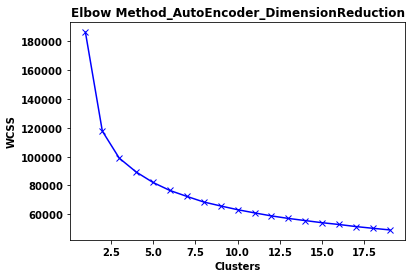

In [14]:
# Define the empty WCSS list to be filled:
wcss_list_encoder = []

# Set the range of clusters to compute over:
list_clusters = range(1, 20)

# Compute the Clusters with K-means to find the optimum numberr of clusters:
for idx in list_clusters:
    kmeans_model = KMeans(n_clusters=idx, 
                          init='k-means++',
                          max_iter=300, 
                          n_init=10, 
                          random_state=101,
                          algorithm='auto')
    
    # fit the model to the dataset:
    kmeans_model.fit(x_dimension_reduced)
    
    # Update/Append the list (WCSS):
    wcss_list_encoder.append(kmeans_model.inertia_)

#  Plot the Elbow Method:
plt.plot(list_clusters, wcss_list_encoder, 'bx-', color = 'b')
plt.title('Elbow Method_AutoEncoder_DimensionReduction')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

Based on the Elbow method, the number of optimum clusters to use is within the range of 5 to 8 (expand to 10 just in case). Therefore set the k_cluster_range=[5, 10].

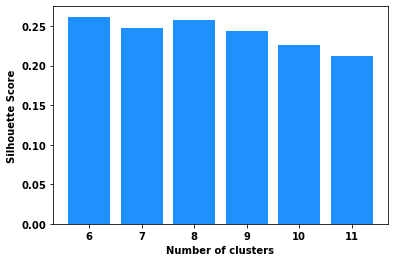

The optimum number of clusters that should be used is: 6
 
 
K-Means algorithm has been fitted with 6-cluster, output dataset it ready for use.
Proceed to Visualising the output results and Cluster Separation check.


In [15]:
if criteria == 0:
    marketing_data_Scaled_labeled_df, marketing_data_nonScaled_labeled_df, labels_Clusters, optimum_cluster_number = k_means_clustering_silhouette(dataset_processed=x_dimension_reduced, 
                                                                                                                                                   dataset_processed_Scaled_df=x_marketing_features_df,
                                                                                                                                                   dataset_processed_nonScaled_df=marketing_nonScaled_df,
                                                                                                                                                   k_cluster_range=[4, 8], 
                                                                                                                                                   plot_charts=True)
else: # criteria == 1
    marketing_data_Scaled_labeled_df, marketing_data_nonScaled_labeled_df, labels_Clusters, optimum_cluster_number = k_means_clustering_silhouette(dataset_processed=x_dimension_reduced, 
                                                                                                                                                   dataset_processed_Scaled_df=x_marketing_features_df,
                                                                                                                                                   dataset_processed_nonScaled_df=marketing_nonScaled_df,
                                                                                                                                                   k_cluster_range=[6, 12], 
                                                                                                                                                   plot_charts=True)

## 6 - Visualise the Cluster Separation:

The following techniques for this section will be:
1. Principal Component Analysis.
2. t-SNE


Original Dataset shape: (7434, 19)
PCA Transformed shape: (7434, 2)


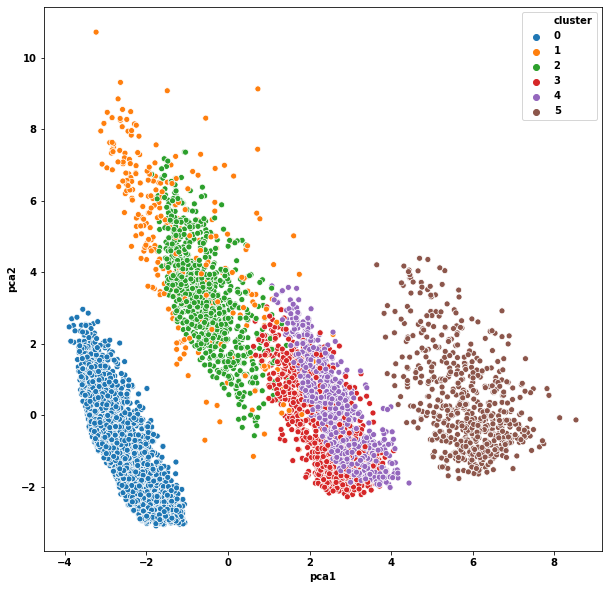

,pca1,pca2,cluster
0,-2.338098,-2.558651,0
1,6.230518,-0.067110,5
2,1.106496,1.646329,3
3,3.099533,0.275661,4
4,-2.223901,-2.516448,0
...,...,...,...
7429,3.148582,-0.364734,4
7430,2.381668,-0.109003,4
7431,3.803884,-1.720838,4
7432,2.378598,0.024400,4


In [16]:
visualise_PCA_plots(dataset_reduced=marketing_data_Scaled_labeled_df, 
                    labels_Clusters=labels_Clusters)

### Observation:

Despite some overlaps in the datapoints like "orange and green" and "purple and red", the clusters can be seen to be separated with a good deal of white space between in the diagonal direction. This is promising because it means that thhe K-Means clusterning algorithm would be able to separate these out appropriately without major overlaps. 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7434 samples in 0.014s...
[t-SNE] Computed neighbors for 7434 samples in 0.458s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7434
[t-SNE] Computed conditional probabilities for sample 2000 / 7434
[t-SNE] Computed conditional probabilities for sample 3000 / 7434
[t-SNE] Computed conditional probabilities for sample 4000 / 7434
[t-SNE] Computed conditional probabilities for sample 5000 / 7434
[t-SNE] Computed conditional probabilities for sample 6000 / 7434
[t-SNE] Computed conditional probabilities for sample 7000 / 7434
[t-SNE] Computed conditional probabilities for sample 7434 / 7434
[t-SNE] Mean sigma: 0.443686
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.381393
[t-SNE] KL divergence after 1000 iterations: 1.571897


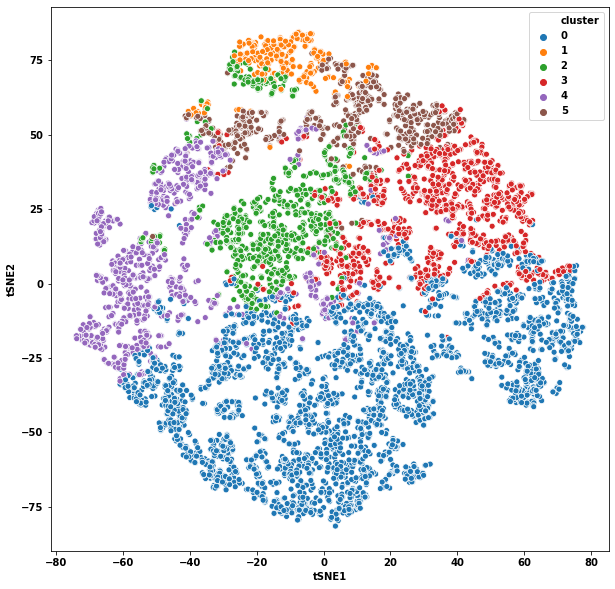

,tSNE1,tSNE2,cluster
0,-18.547140,-56.257202,0
1,12.327150,61.692436,5
2,7.698546,1.803306,3
3,-55.007935,13.377192,4
4,29.386065,-43.136650,0
...,...,...,...
7429,-36.825592,47.517281,4
7430,-45.811886,32.791370,4
7431,-31.561169,44.177151,4
7432,-46.171425,33.440475,4


In [17]:
visualise_tSNE_plots(dataset_processed=x_dimension_reduced, 
                     labels_Clusters=labels_Clusters)

## 7 - Visualise Cluster Attributes for Marketing Department:

Here, the indivual cluster histograms will be plotted out. These should show the __Segmented customer behaviour__ in each cluster and will provide valuable insights to the Marketing Department for designing a targeted marketing campaign.

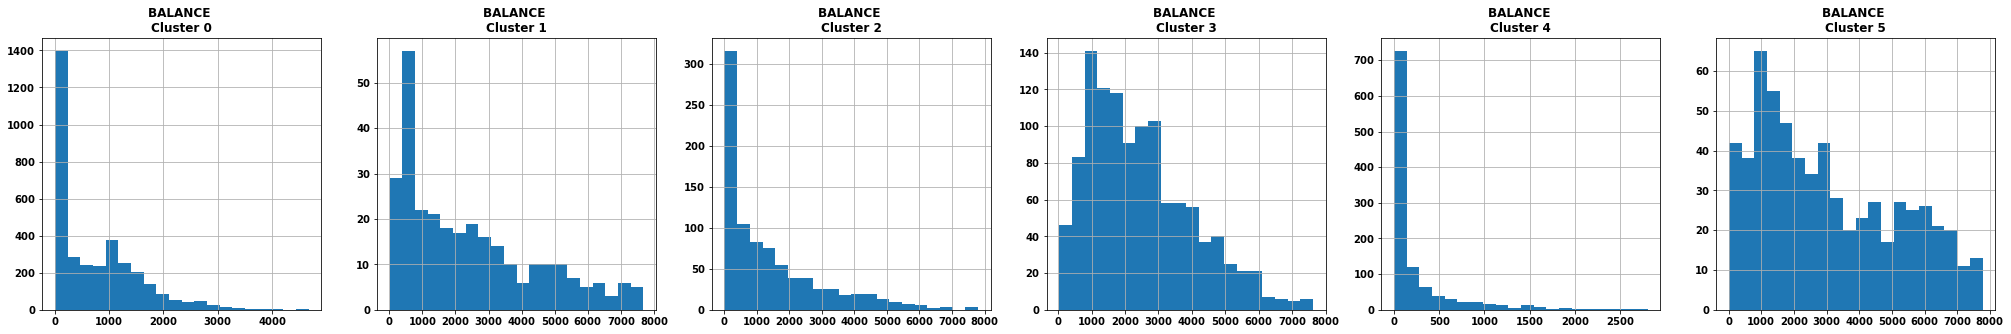

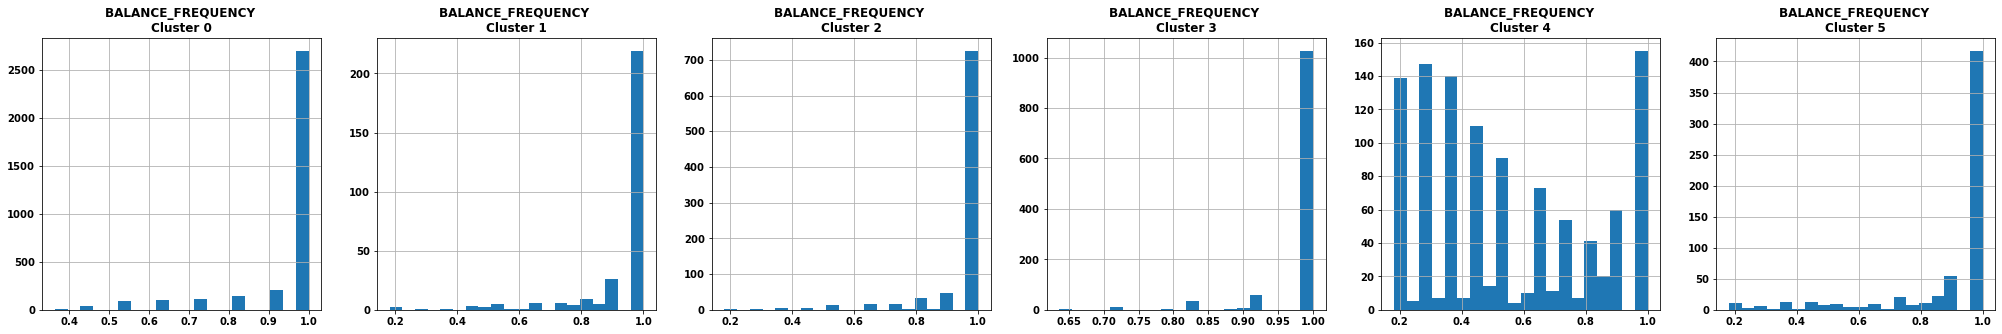

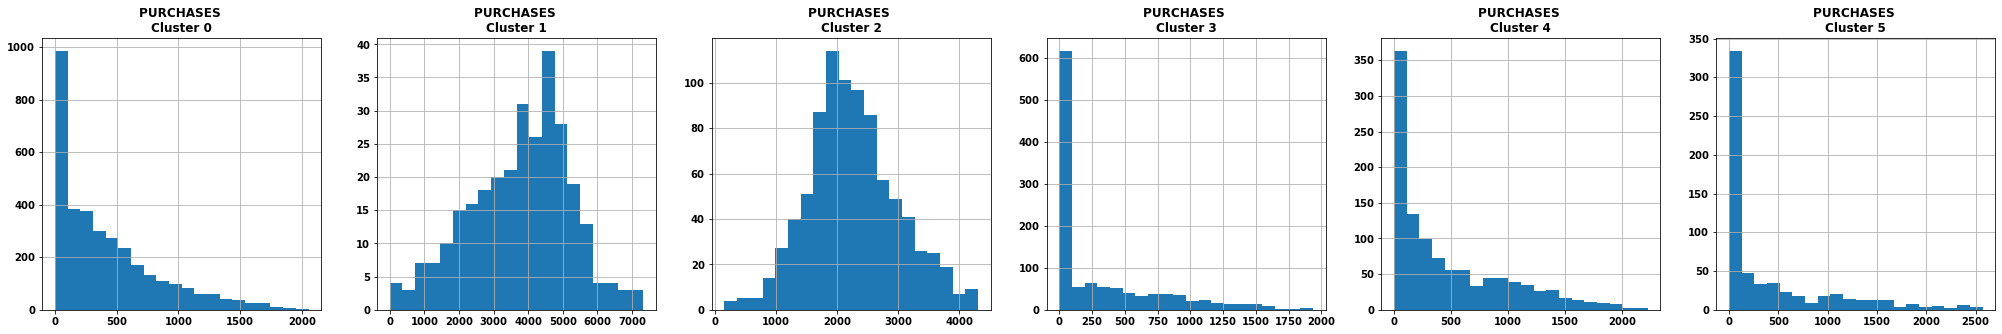

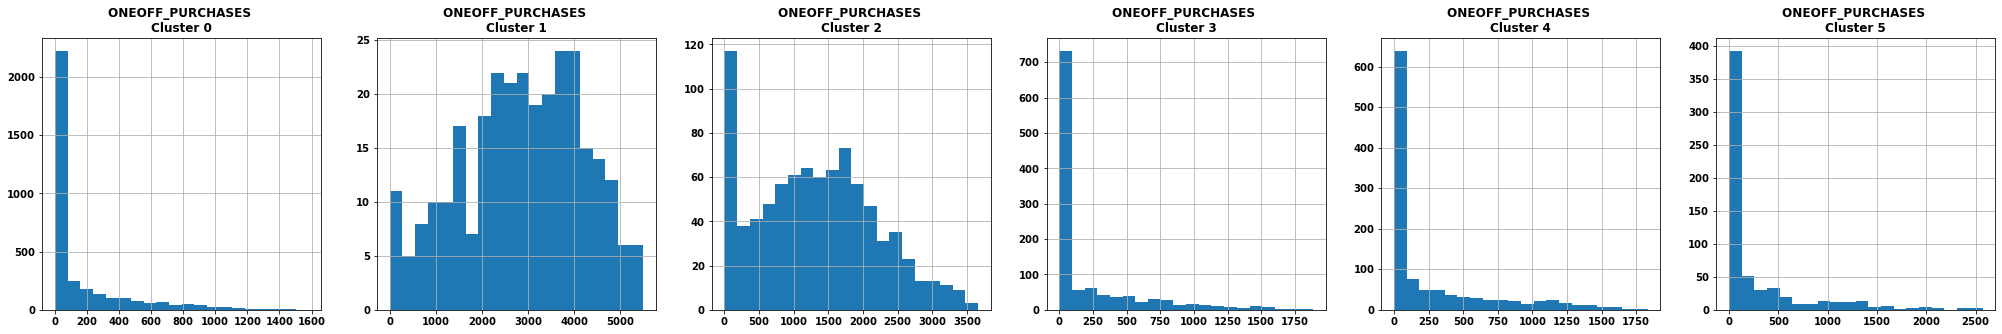

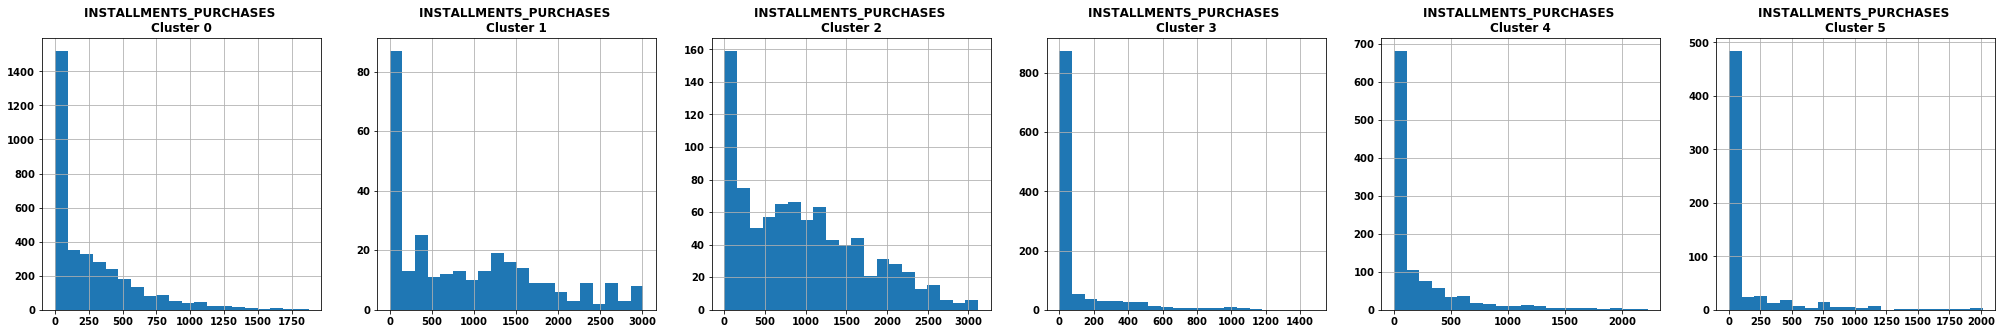

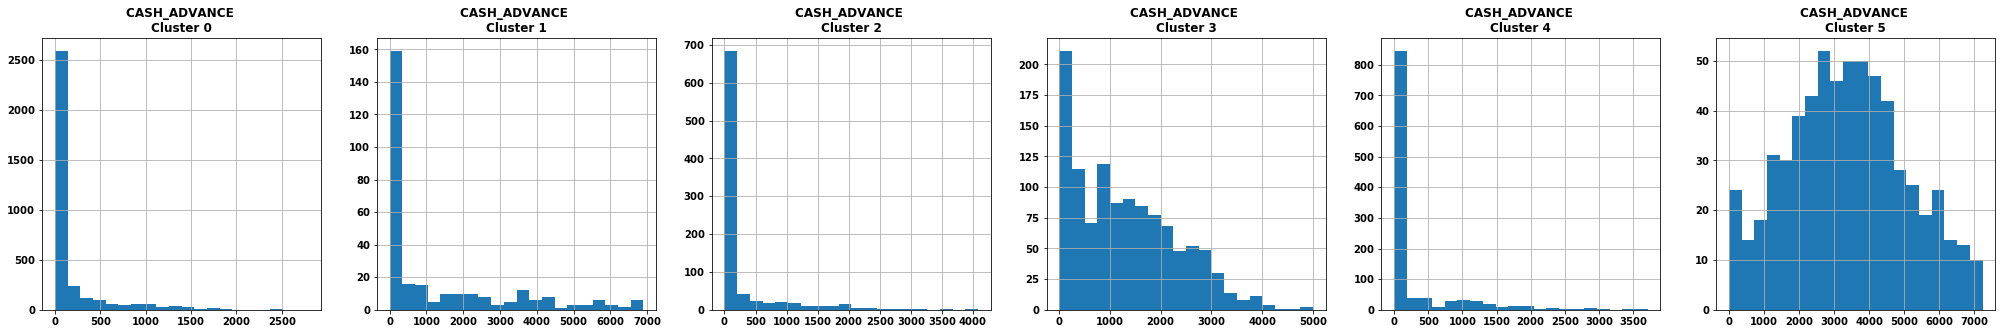

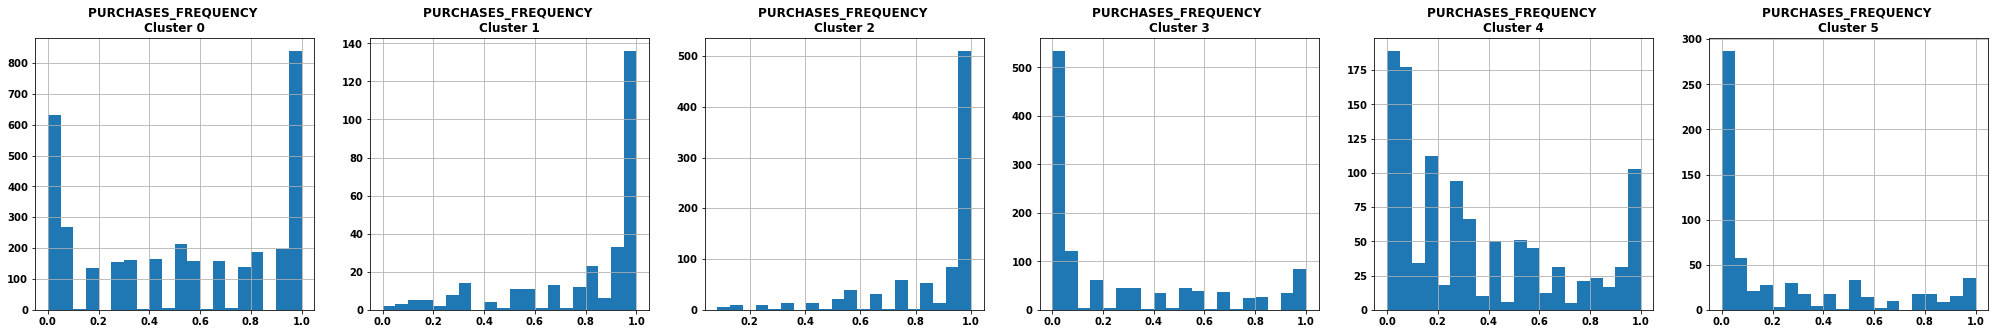

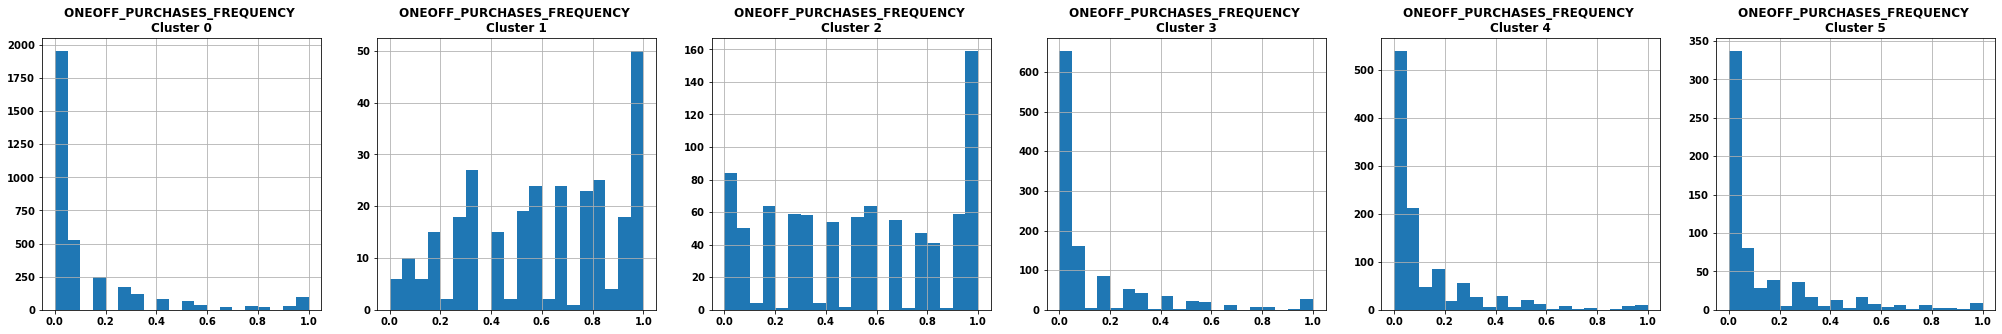

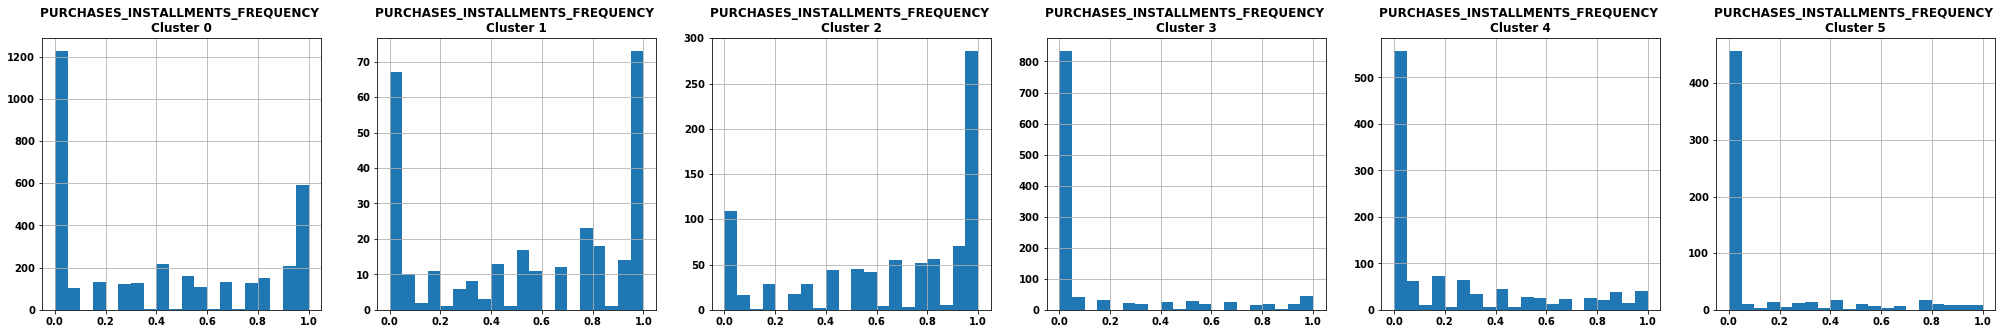

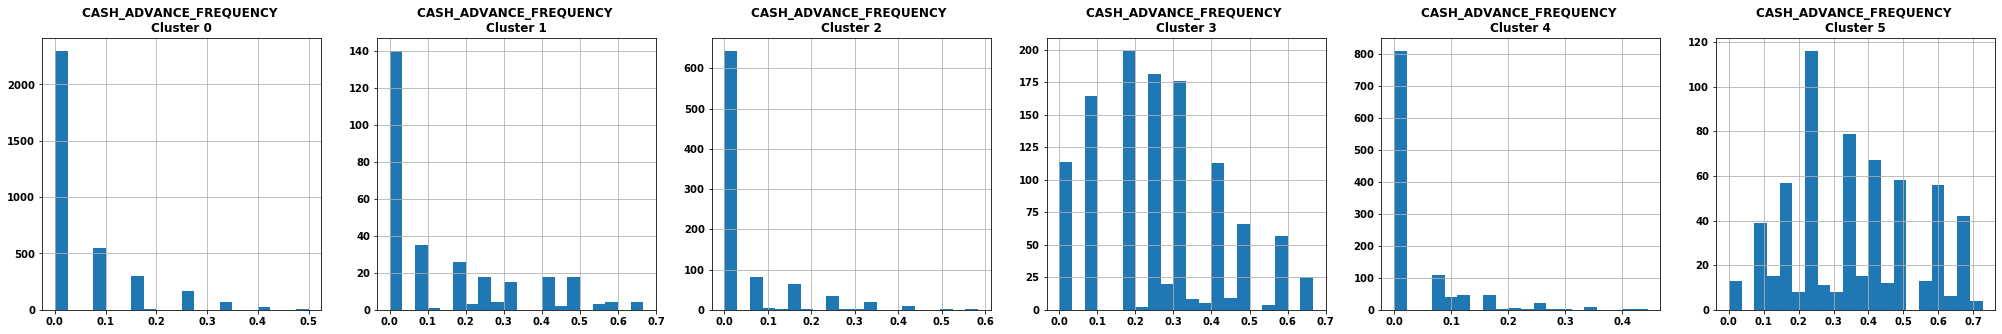

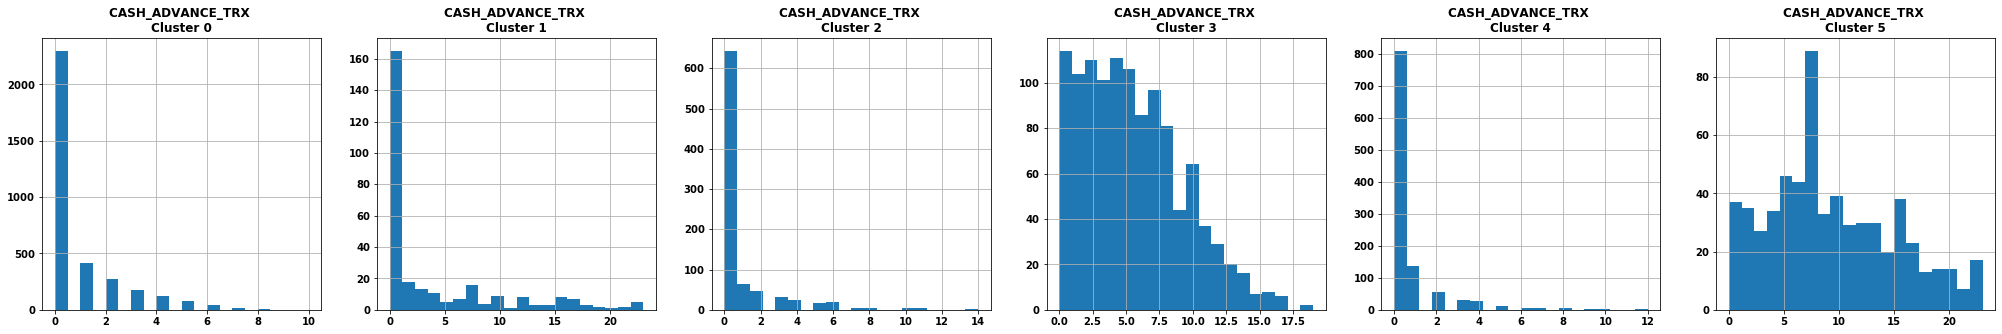

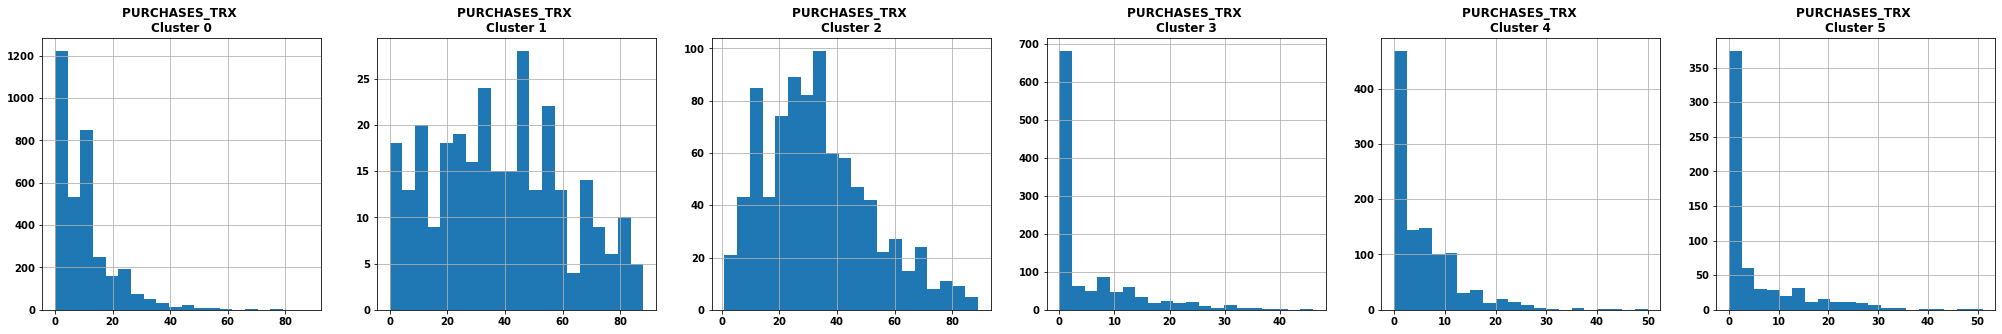

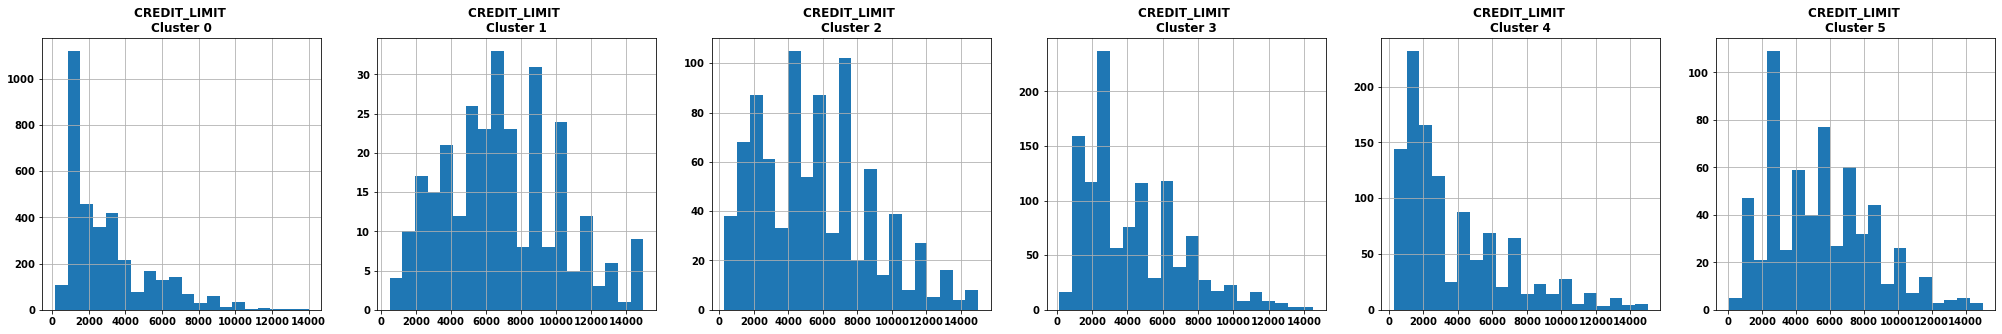

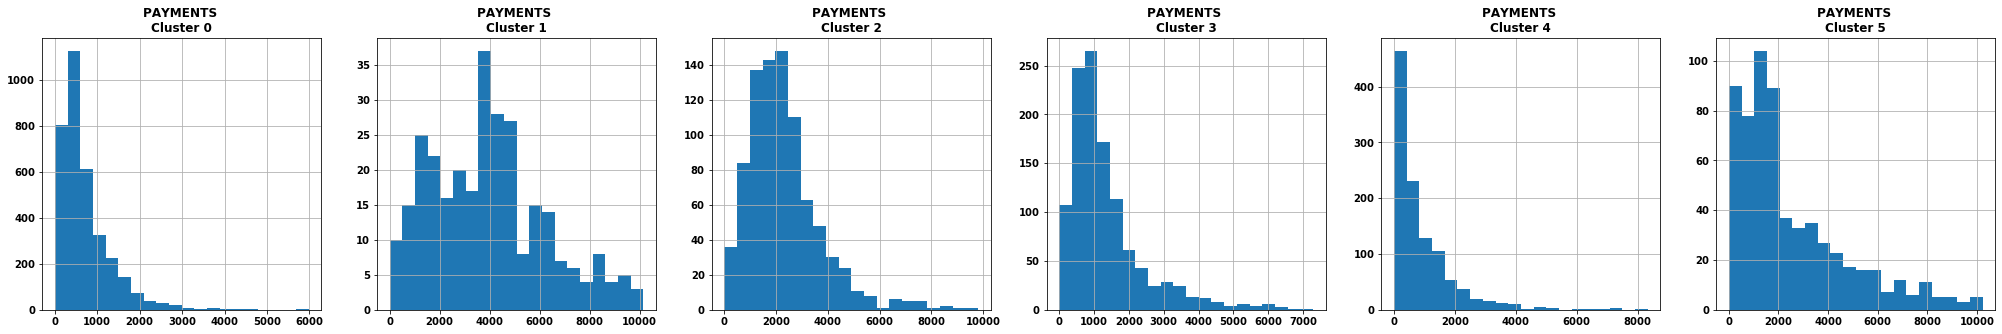

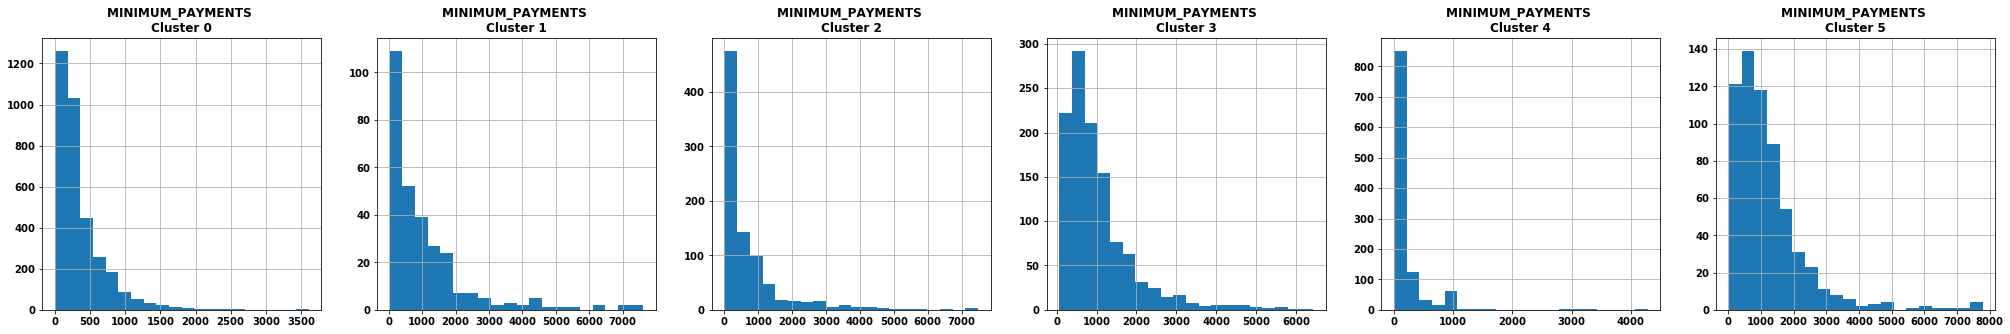

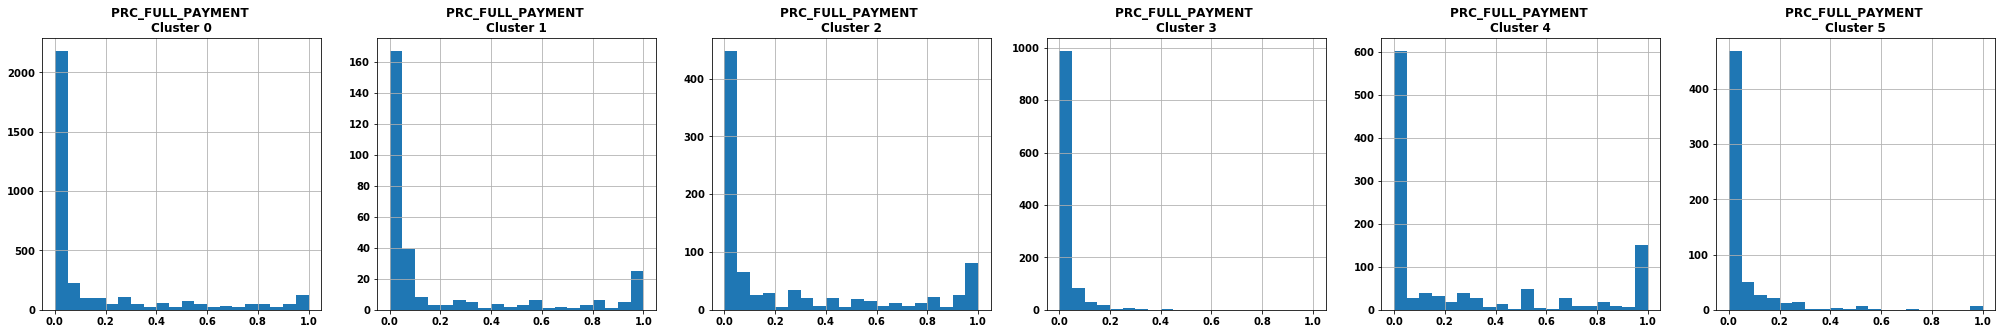

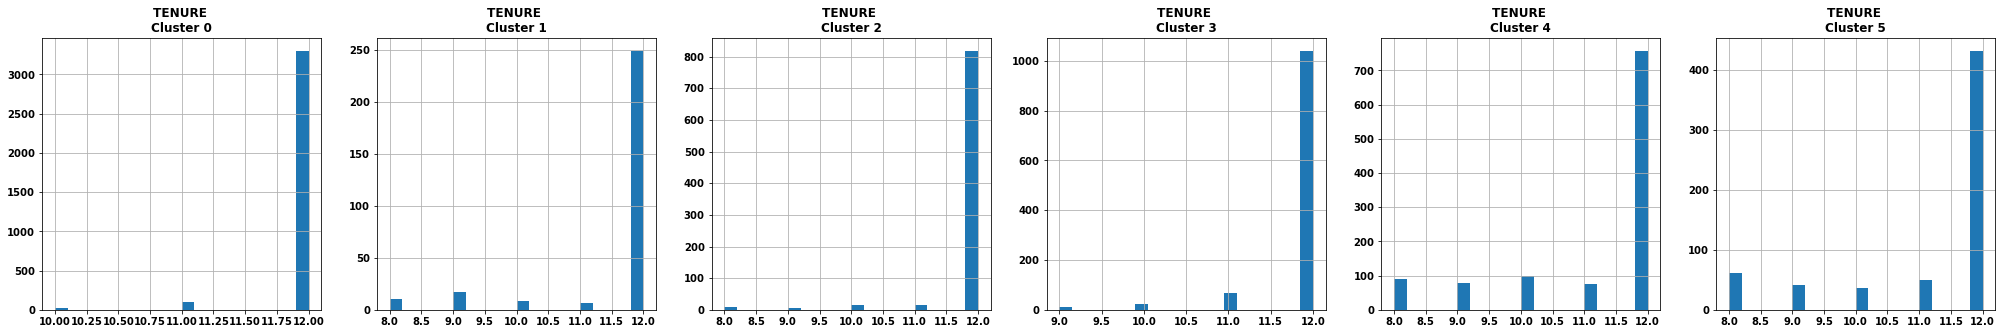

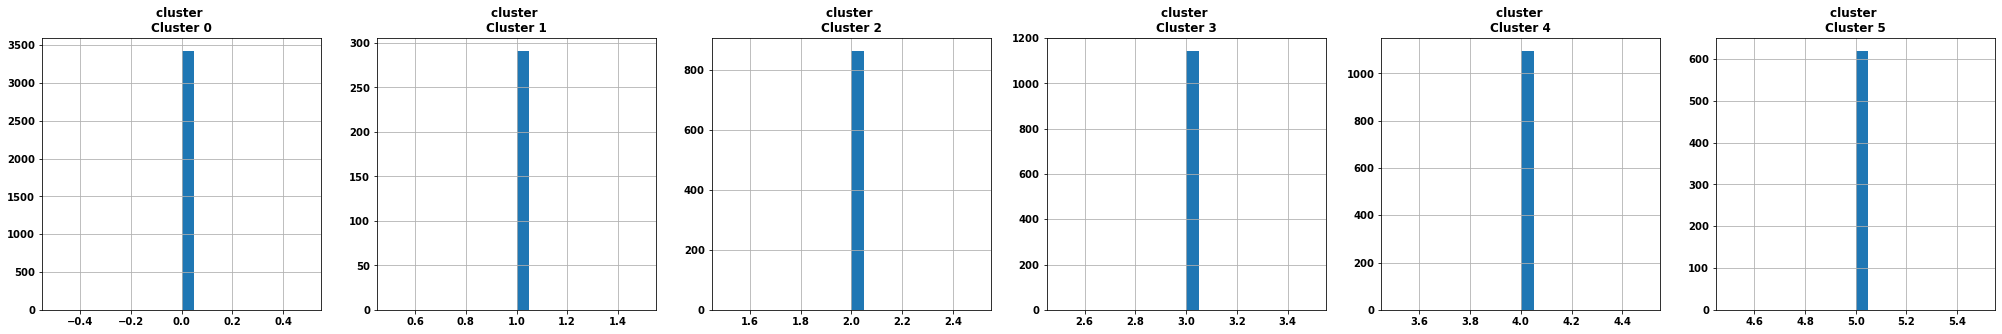

In [18]:
data_labeled_df, stats_df= visualise_kMeans_results(dataset_original=marketing_data_nonScaled_labeled_df, 
                                                    labels_Clusters=labels_Clusters, 
                                                    optimum_cluster_number=optimum_cluster_number,
                                                    cluster_number=None,
                                                    plot_overall=True, 
                                                    plot_cluster=False)

### 7.1 - Check out Individual Clusters:

For __Cluster 0__.

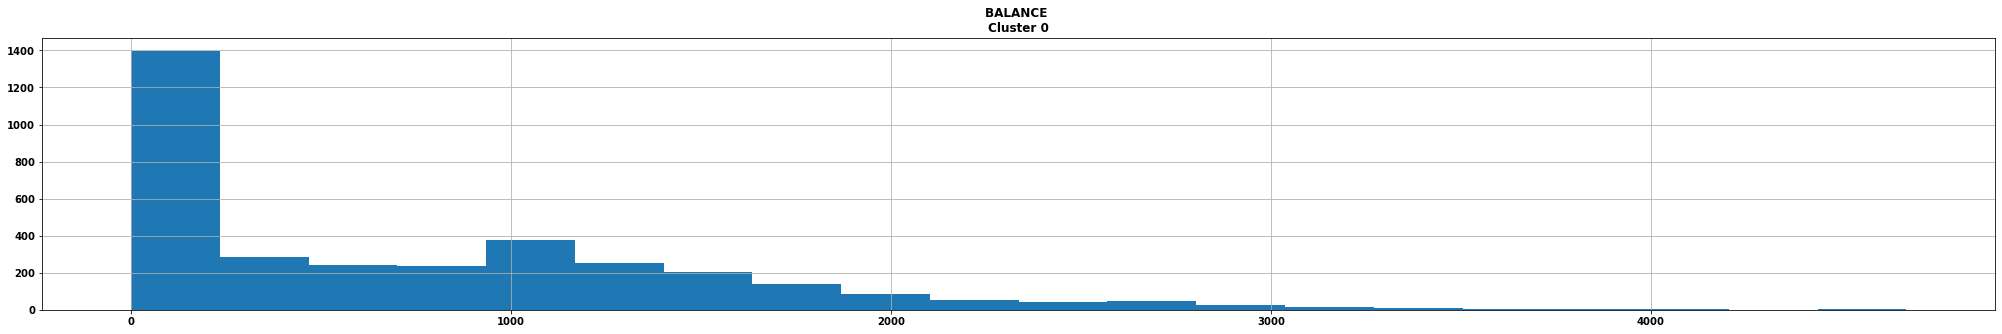

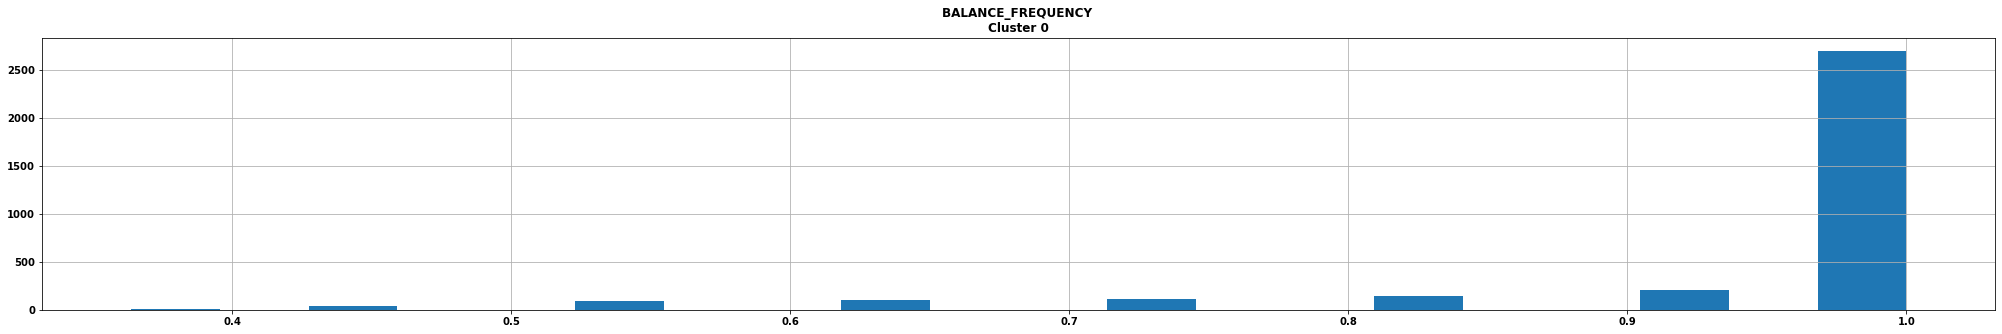

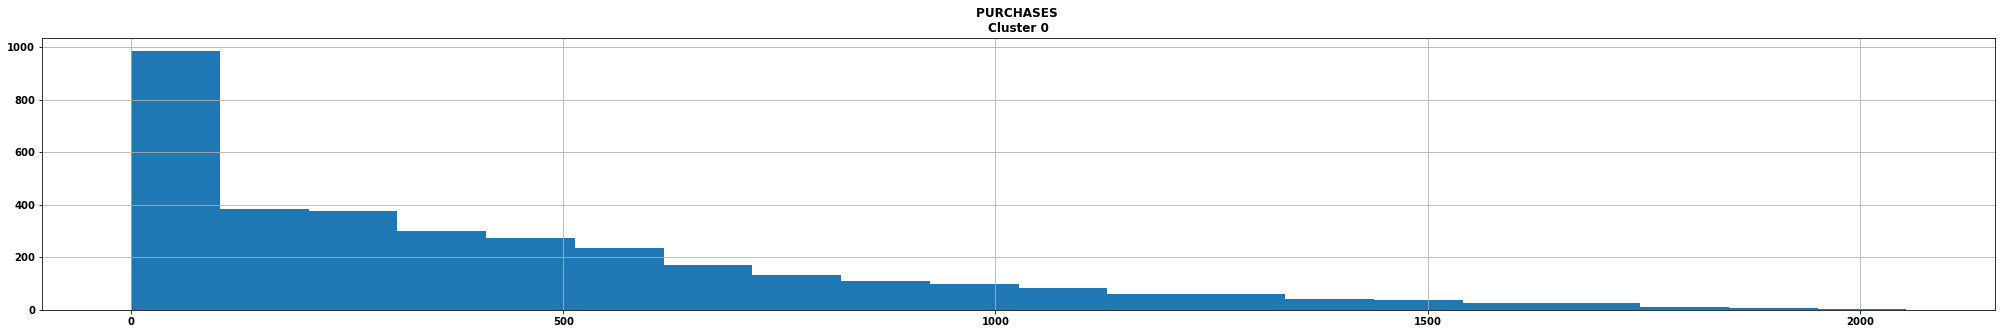

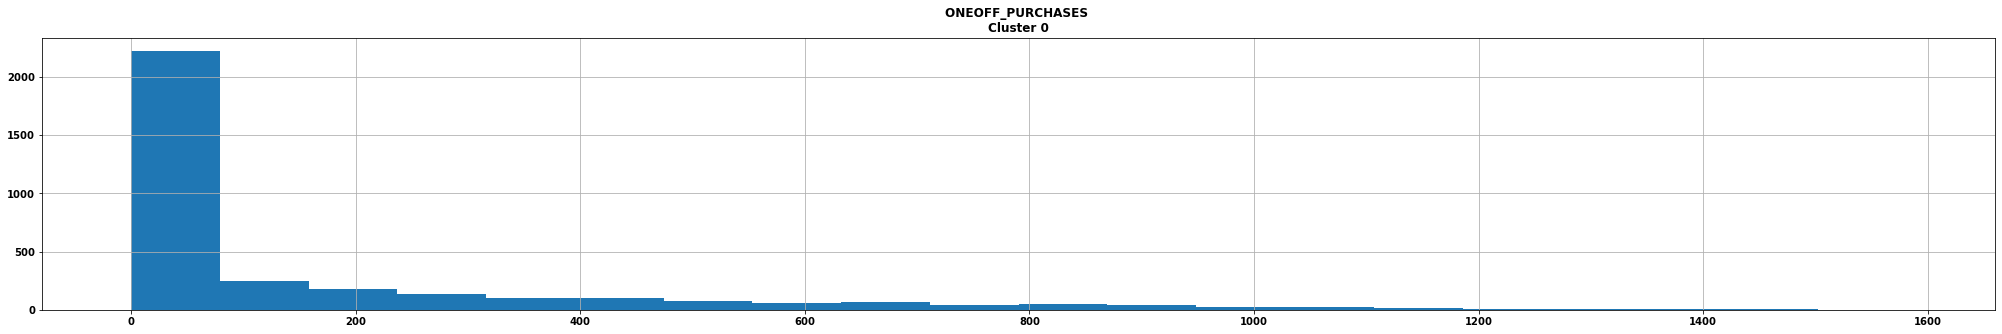

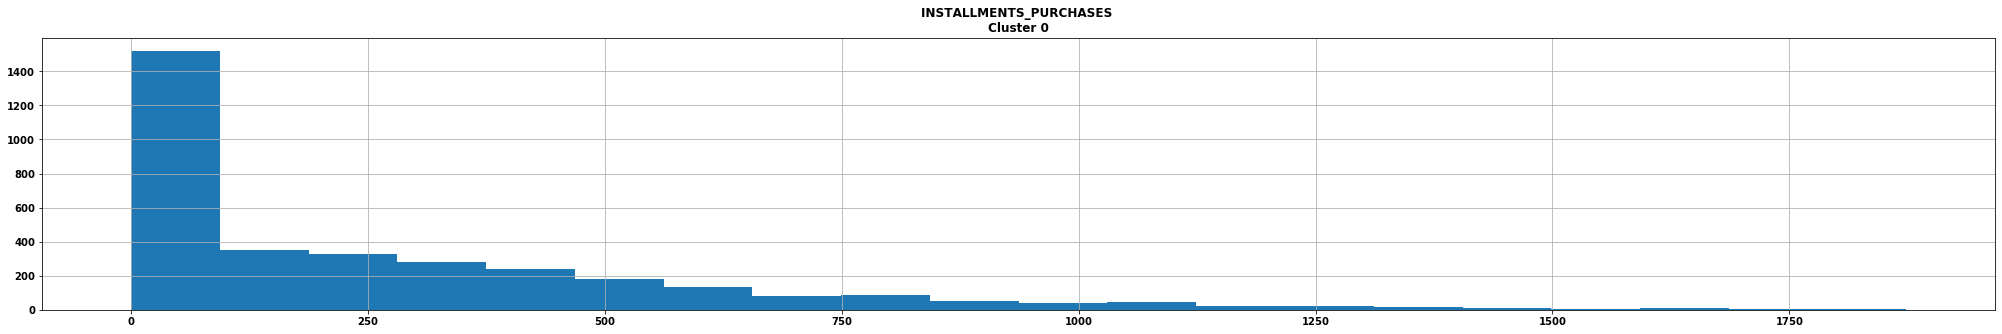

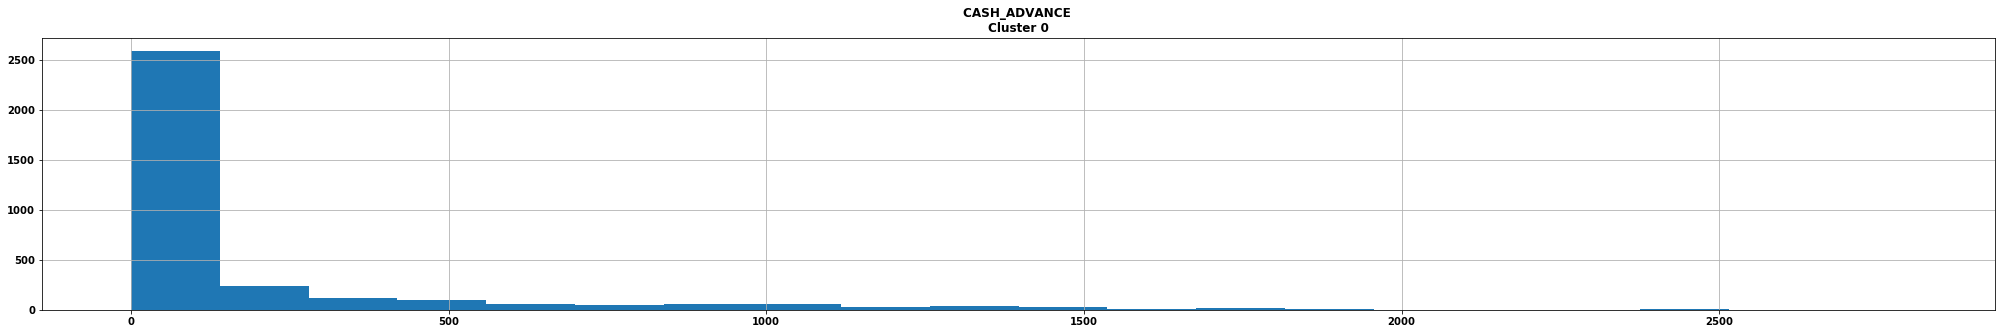

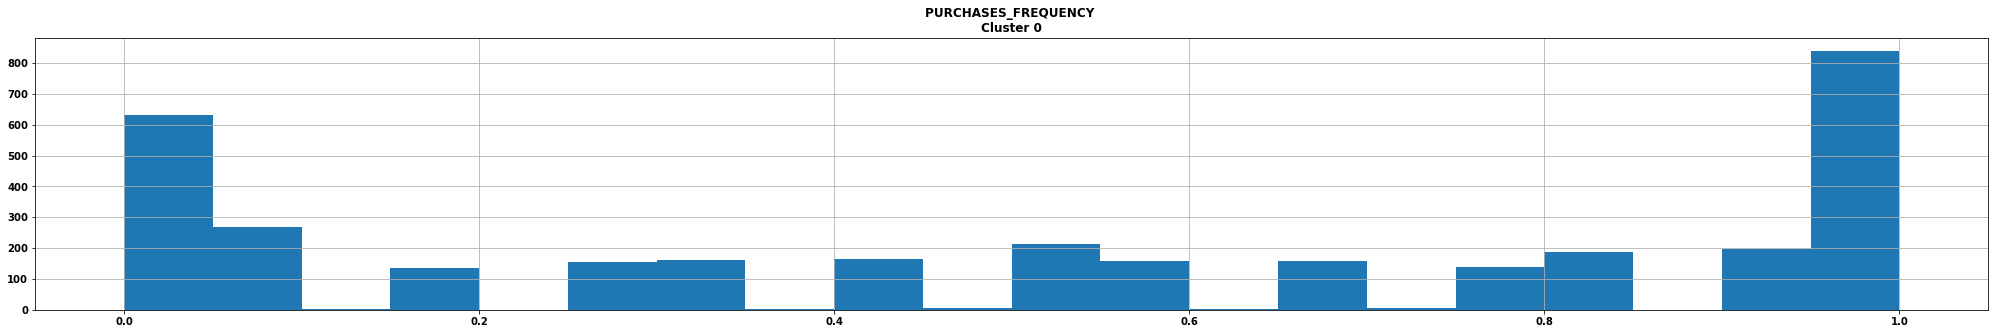

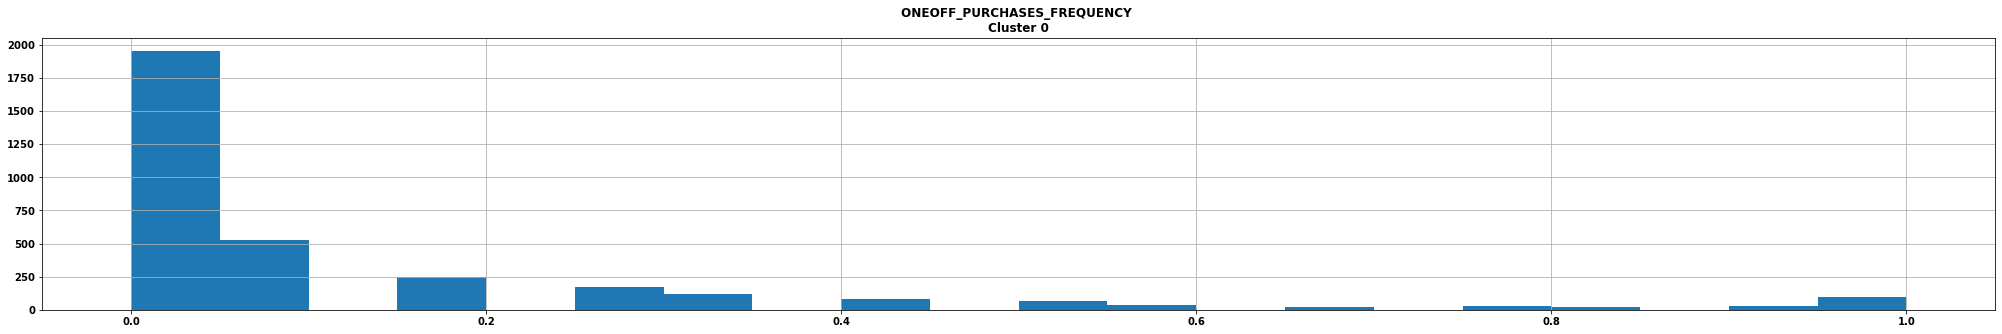

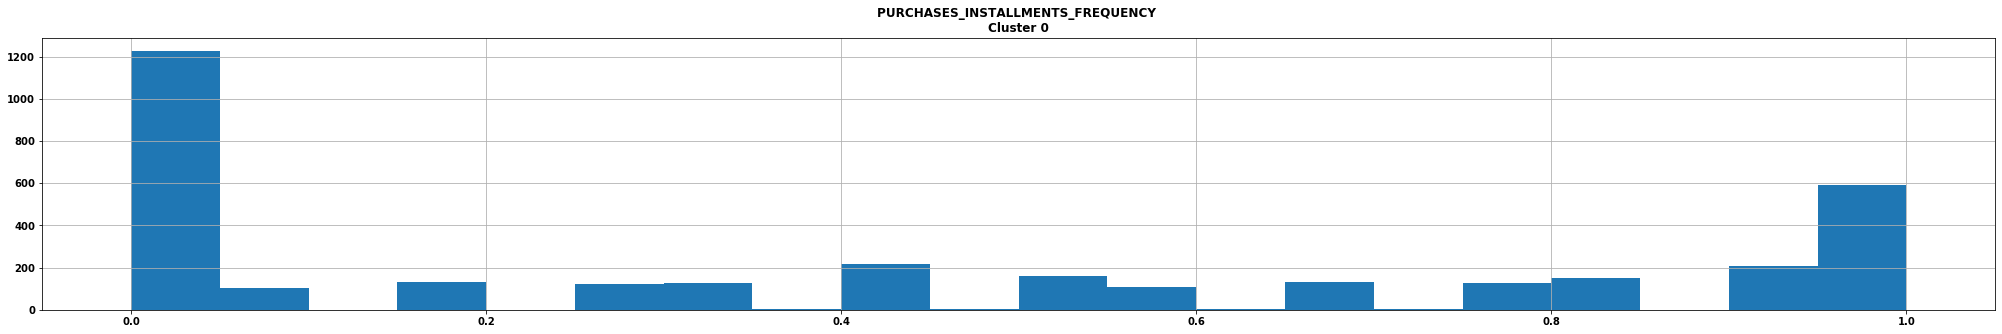

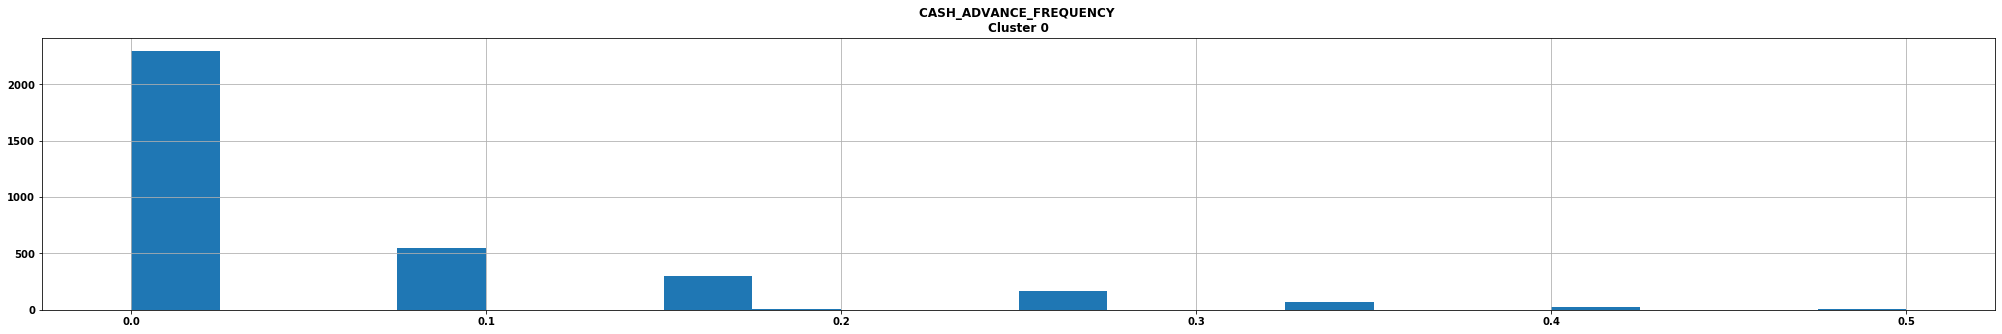

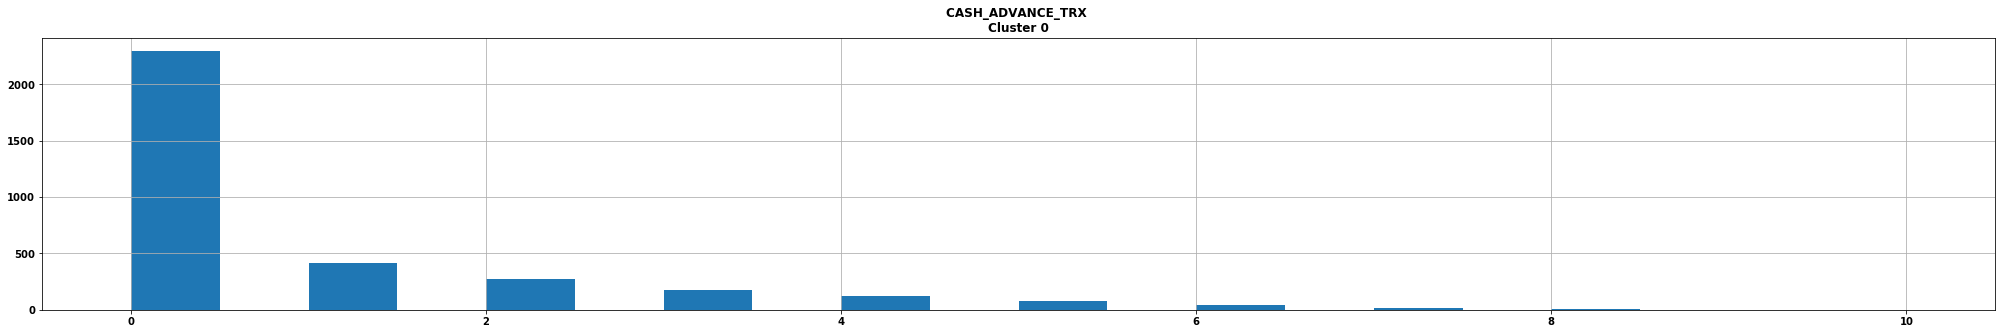

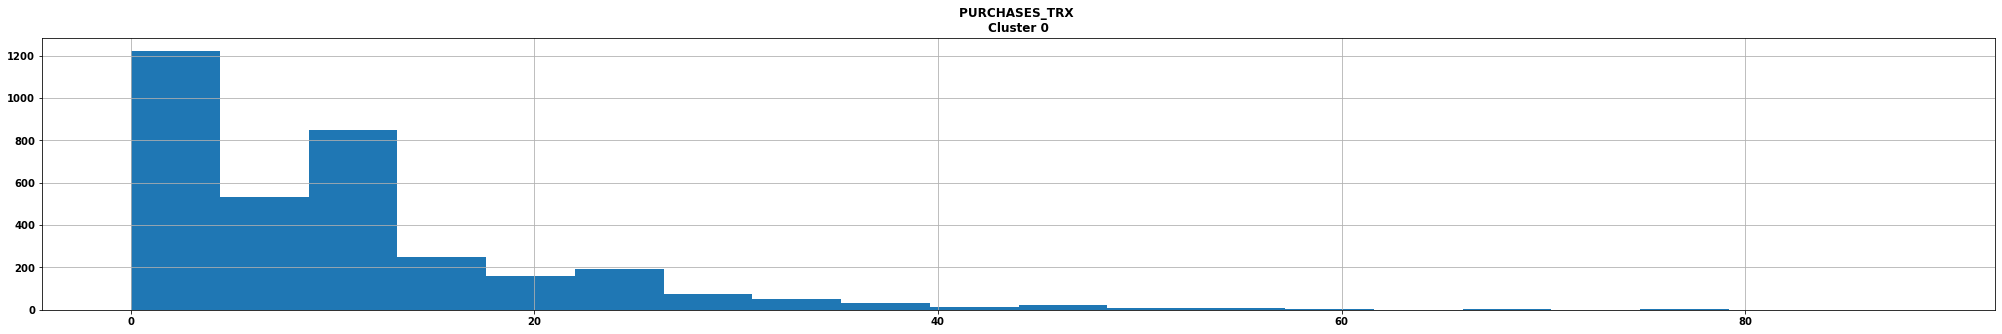

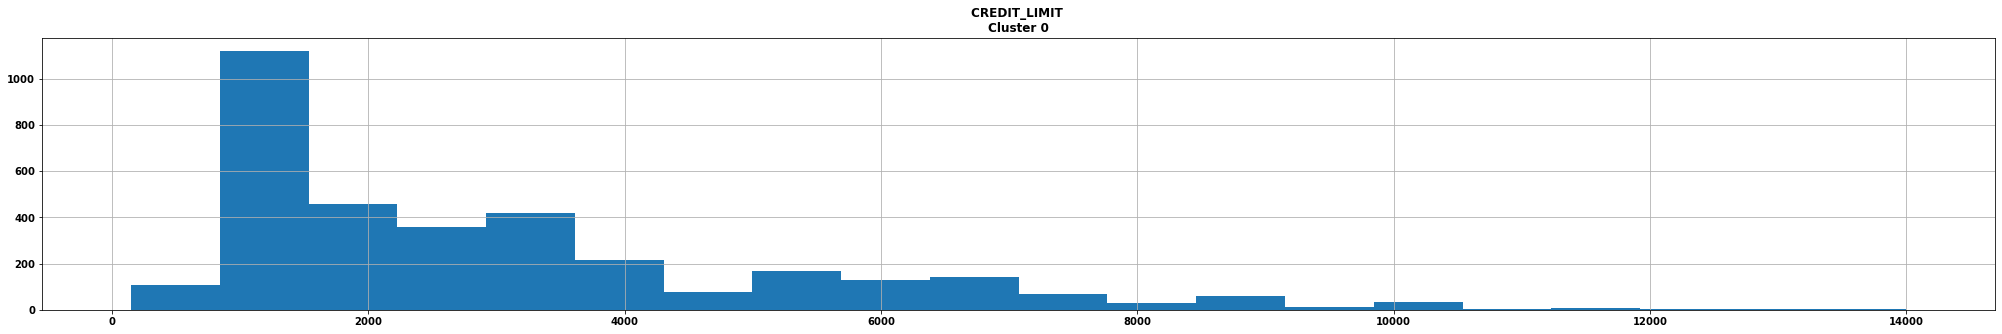

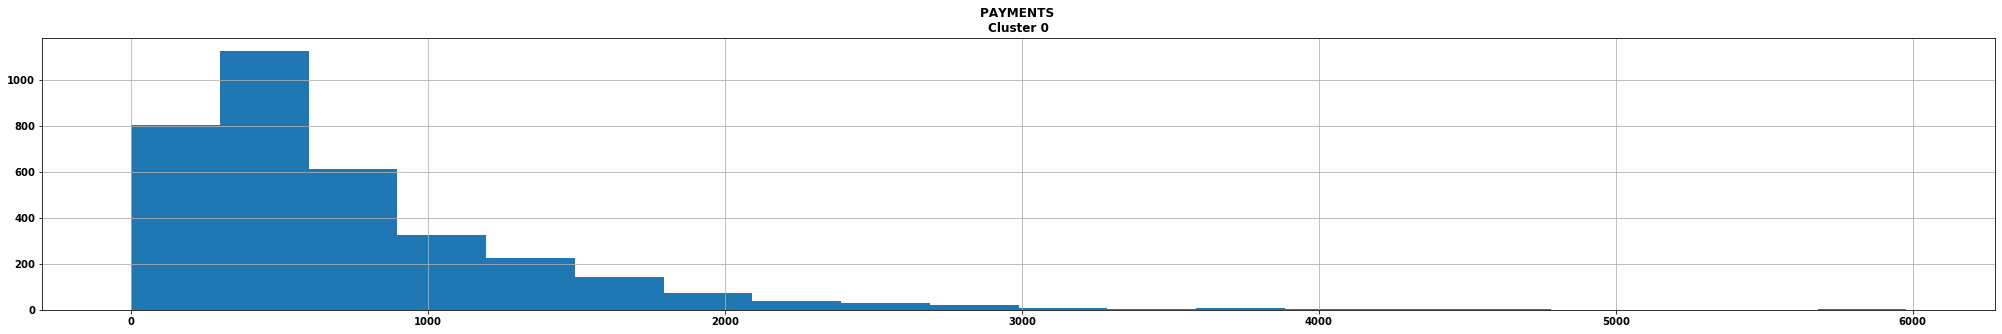

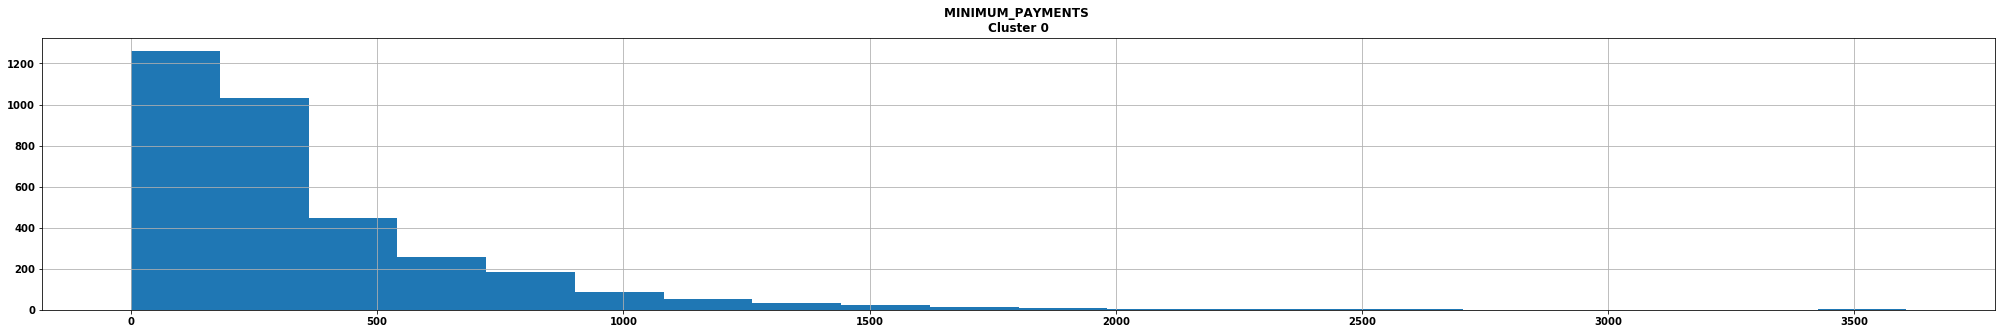

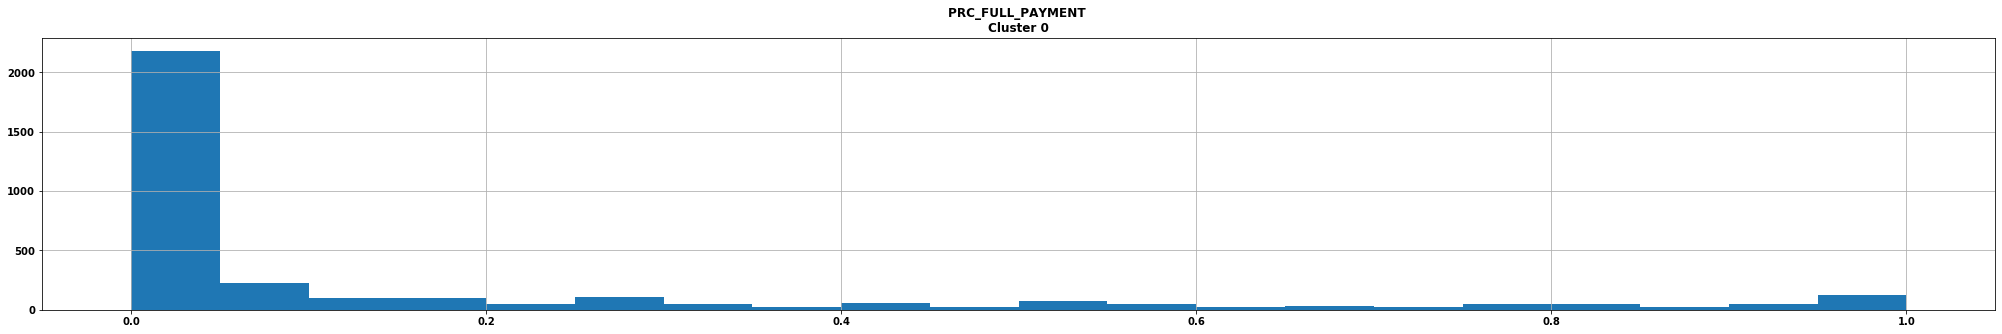

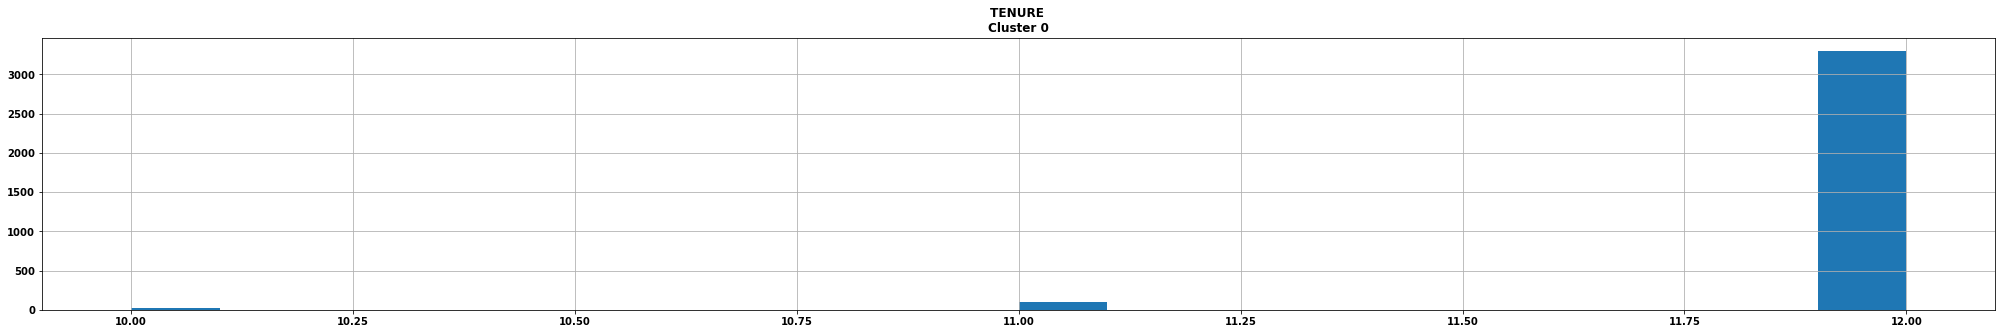

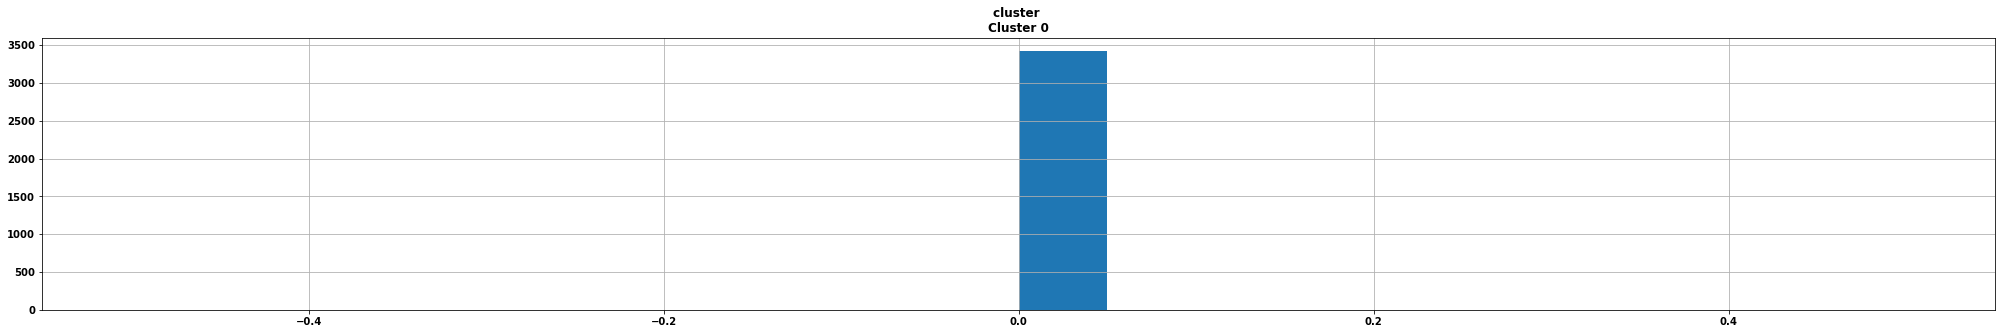

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.0
mean,740.987969,0.945160,416.207501,155.565313,260.915847,165.676364,0.525437,0.129178,0.420335,0.051319,0.808591,9.875804,3014.184215,711.723494,367.468442,0.156988,11.959088,0.0
std,775.298284,0.126513,419.397759,276.291420,328.922121,365.682064,0.386710,0.234068,0.398429,0.089079,1.475279,10.099769,2251.794589,608.684534,352.919508,0.282957,0.223098,0.0
min,0.004816,0.363636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,0.037744,0.000000,10.000000,0.0
25%,72.204043,1.000000,71.850000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,308.988439,164.627721,0.000000,12.000000,0.0
50%,482.217943,1.000000,297.305000,0.000000,143.910000,0.000000,0.500000,0.000000,0.390151,0.000000,0.000000,8.000000,2400.000000,539.179451,217.360623,0.000000,12.000000,0.0
75%,1193.620082,1.000000,622.785000,200.000000,410.022500,119.895857,0.916667,0.166667,0.833333,0.083333,1.000000,13.000000,4000.000000,915.612806,462.371601,0.166667,12.000000,0.0
max,4672.628863,1.000000,2053.780000,1580.980000,1873.560000,2794.719183,1.000000,1.000000,1.000000,0.500000,10.000000,88.000000,14000.000000,5978.807577,3605.683246,1.000000,12.000000,0.0


In [19]:
data_labeled_df, stats_df= visualise_kMeans_results(dataset_original = marketing_data_nonScaled_labeled_df, 
                                                    labels_Clusters=labels_Clusters, 
                                                    optimum_cluster_number=optimum_cluster_number,
                                                    cluster_number=0,
                                                    plot_overall=False, 
                                                    plot_cluster=True)

stats_df

### Observation:

General Behaviour of Cluster 0 customers:
- These customers have a mean balance of ~USD740.
- These customers also have frequent changes to their balances and make purchases on products that is around ~USD420.
- The one-off purchases are typically around ~USD155 and presents with a lower fequency of ~0.13.
- These customers also tend to pay off 15.69% of the full payment monthly with this credit card.
- These customers are also very loyal with a tenure of around ~12 years with this bank

Overall, these are customers can be said to be very loyal, pays lower interests and careful with their money.

For __Cluster 5__.

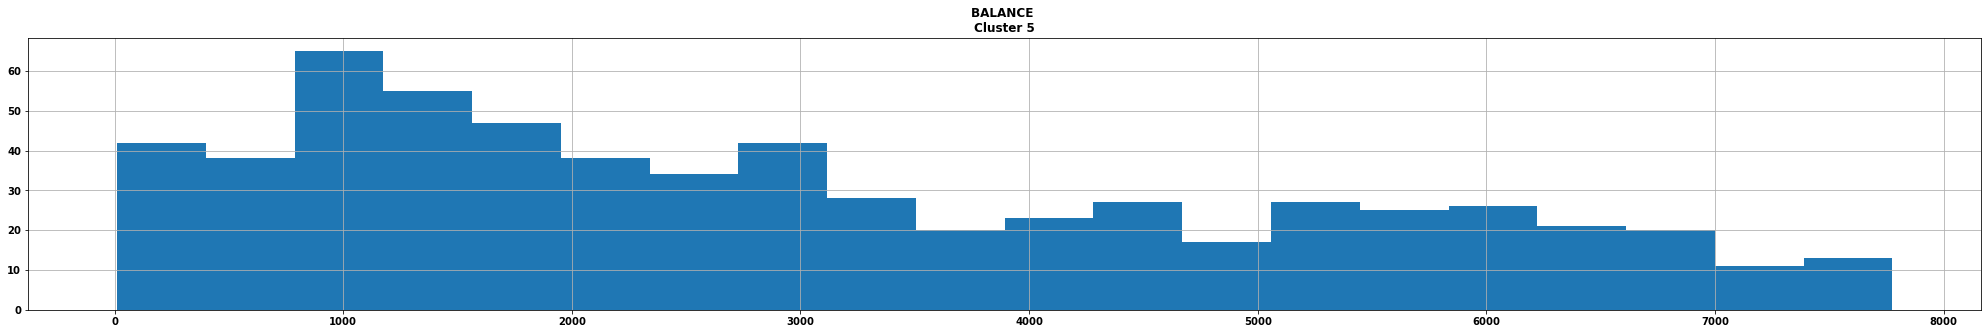

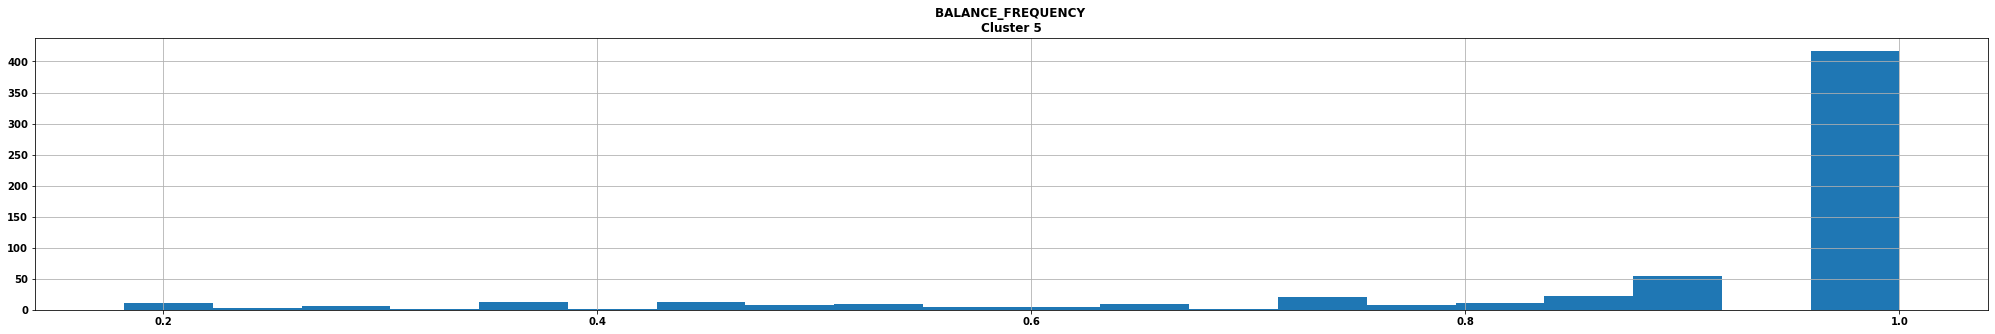

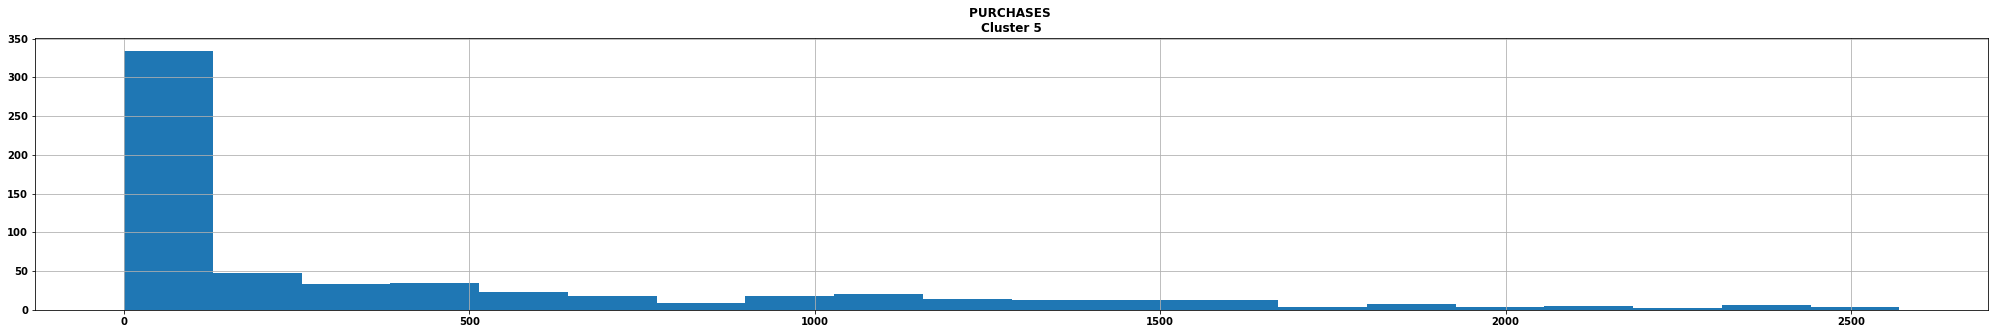

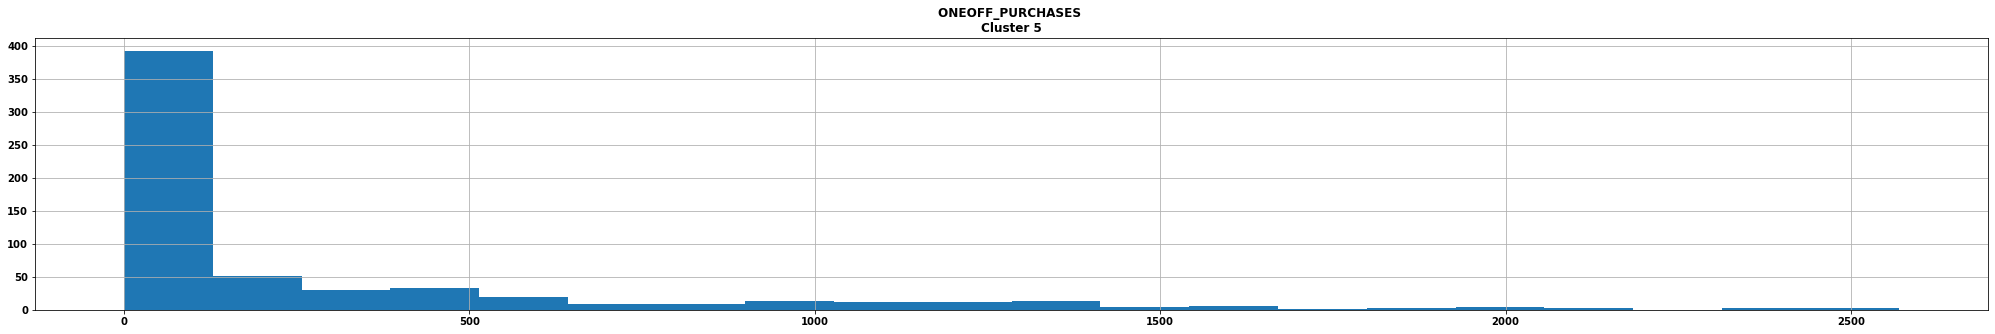

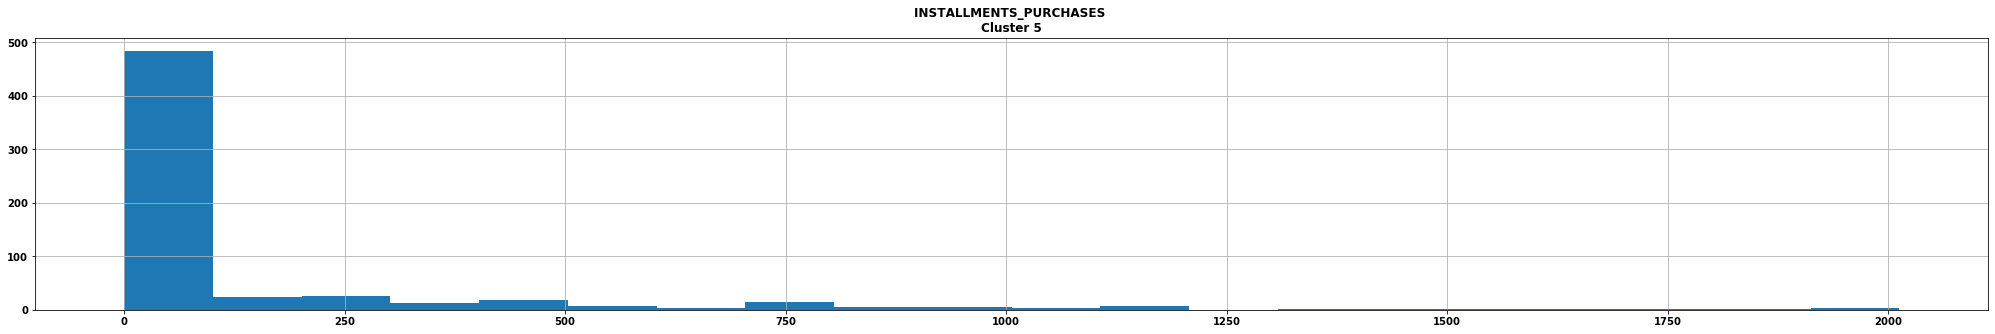

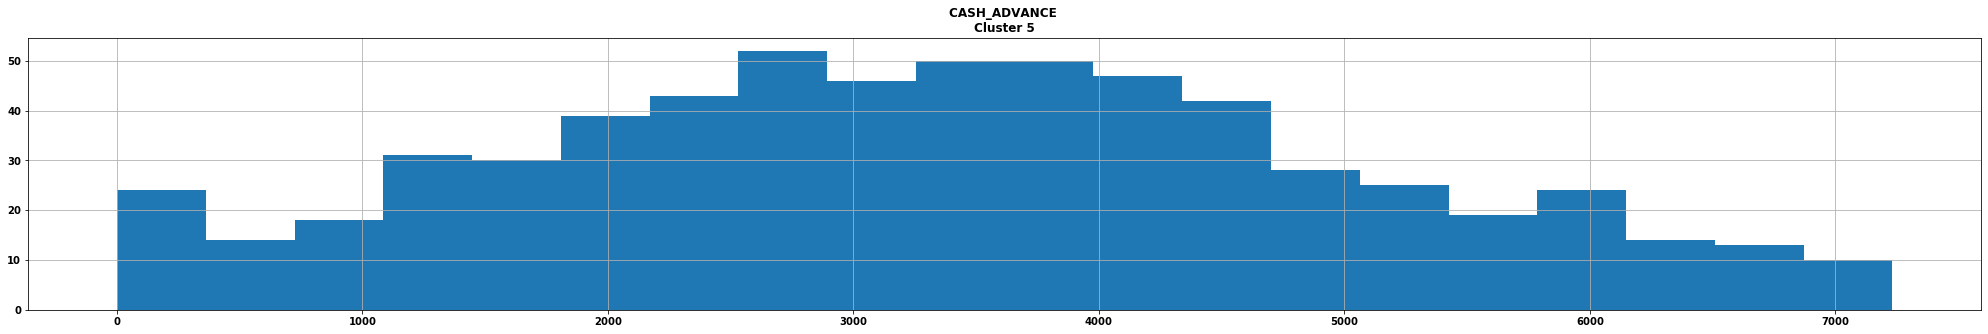

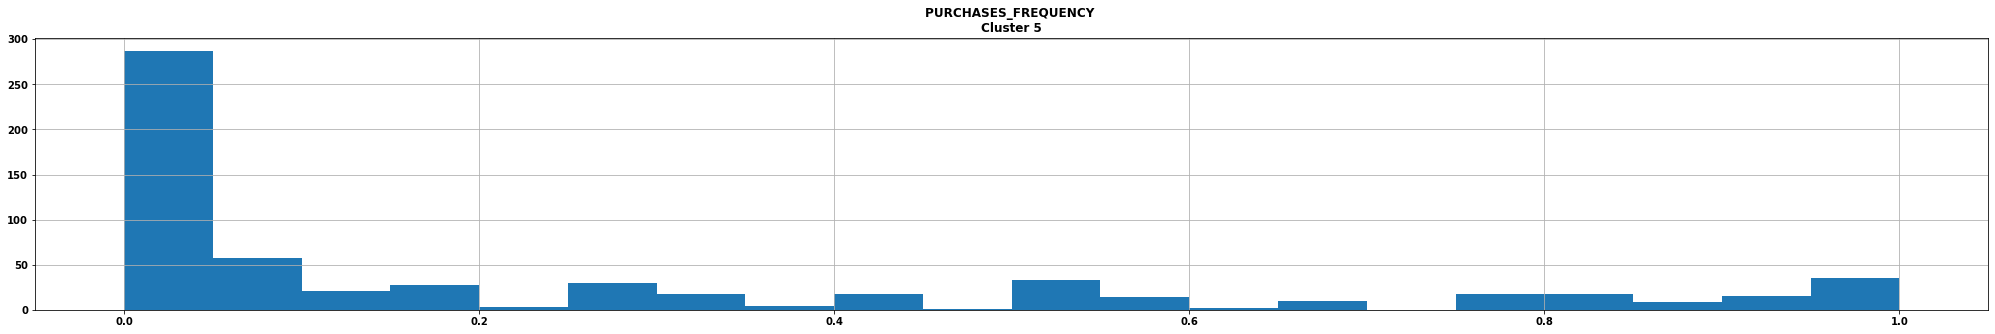

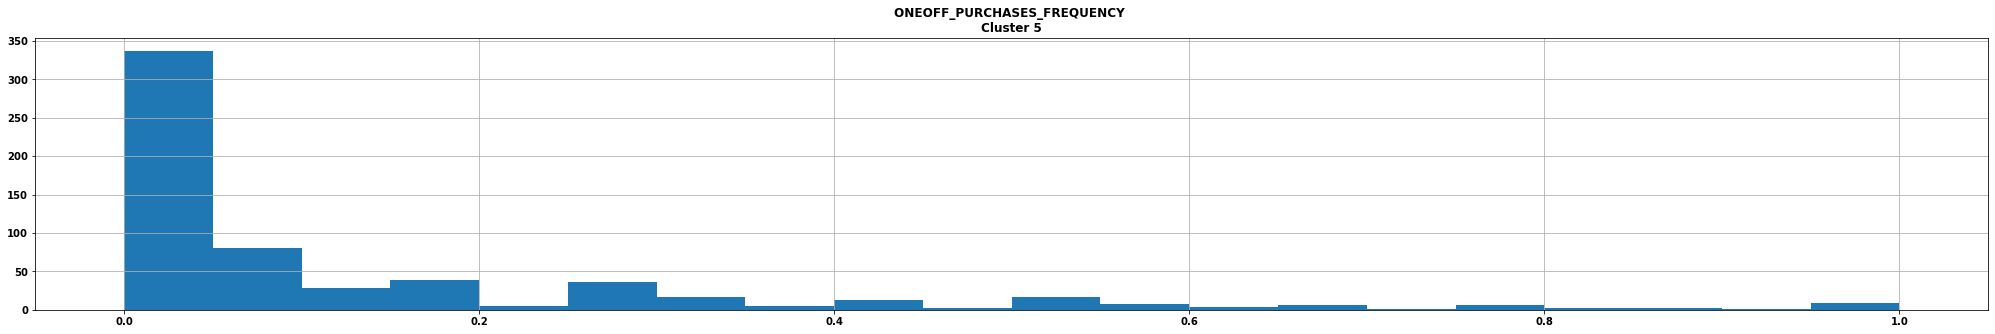

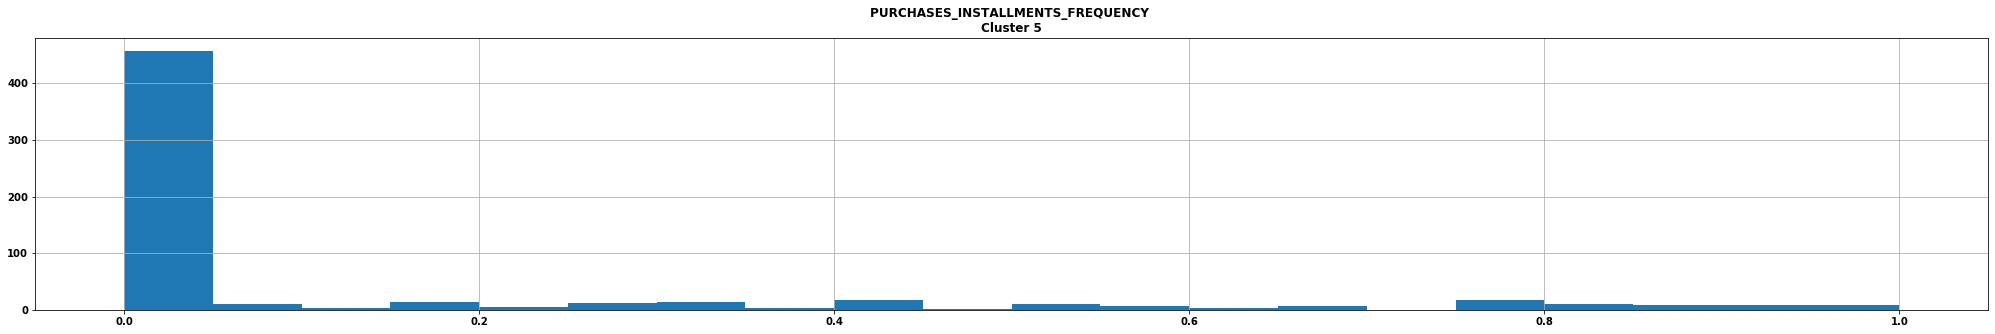

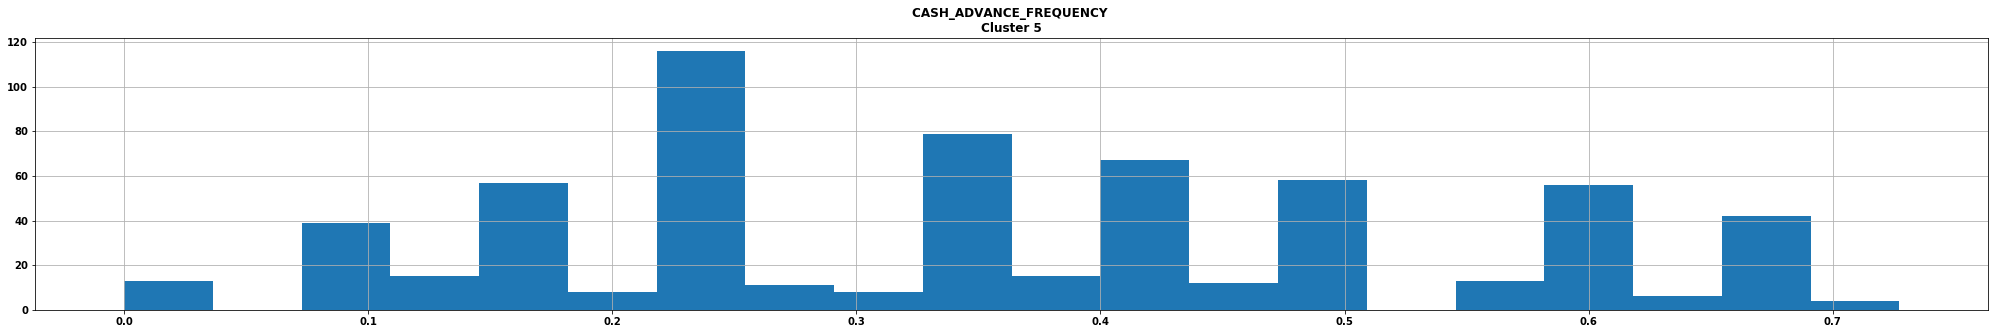

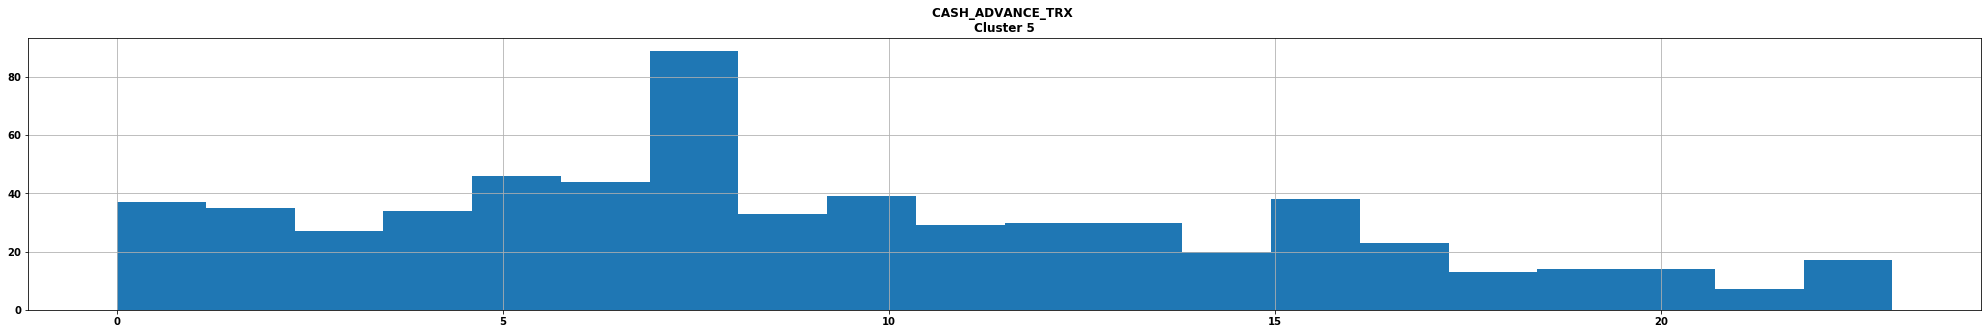

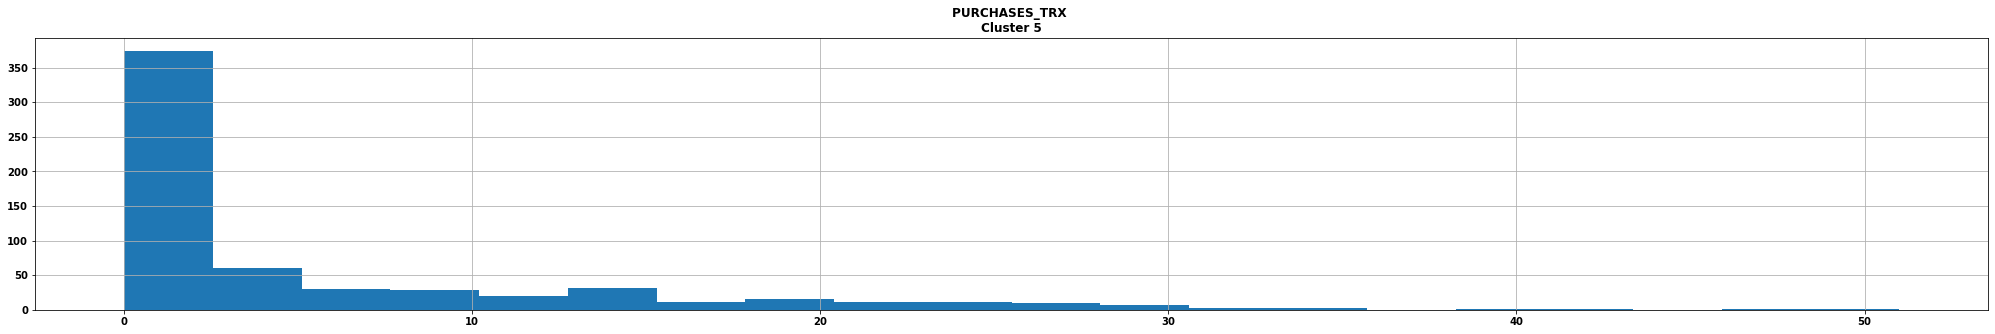

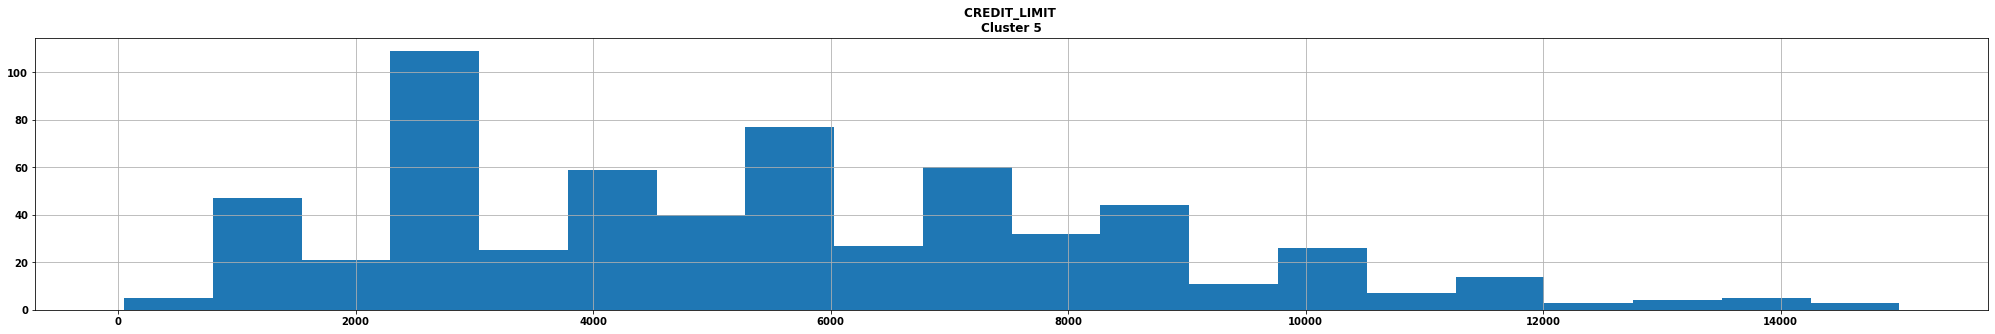

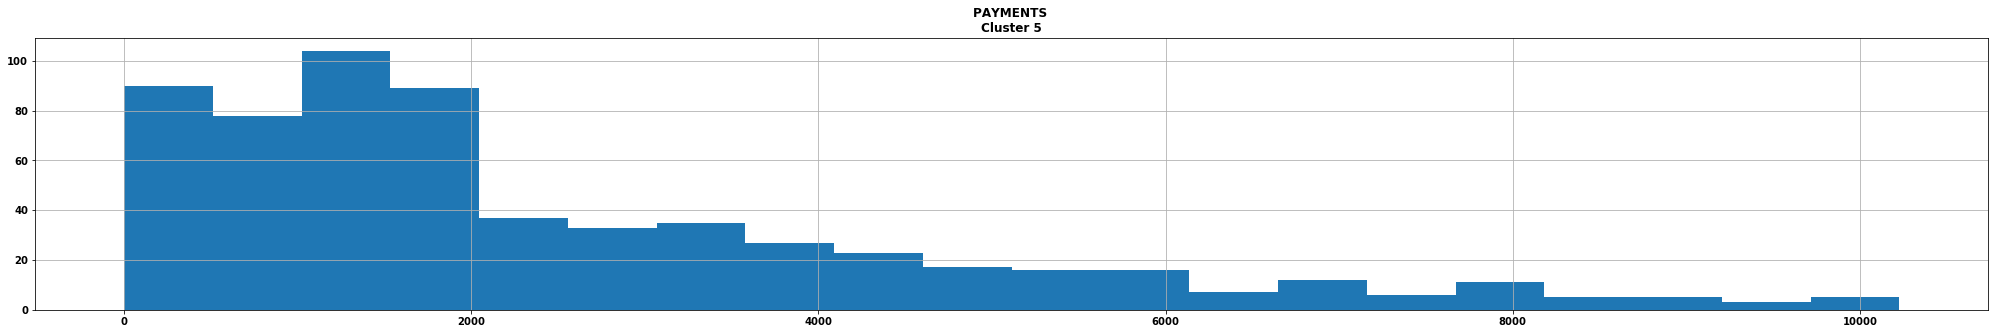

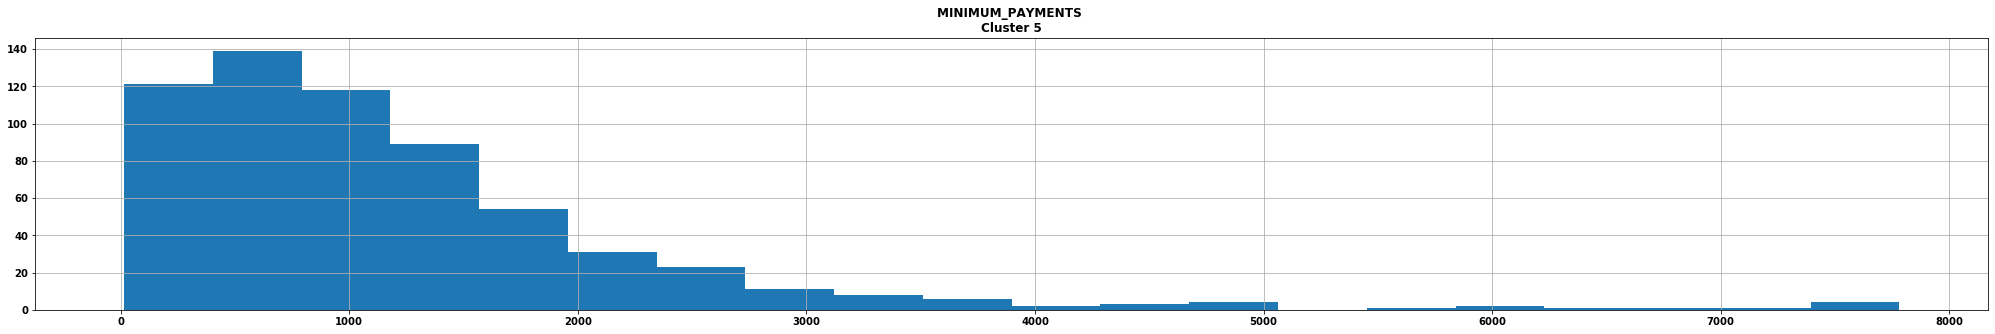

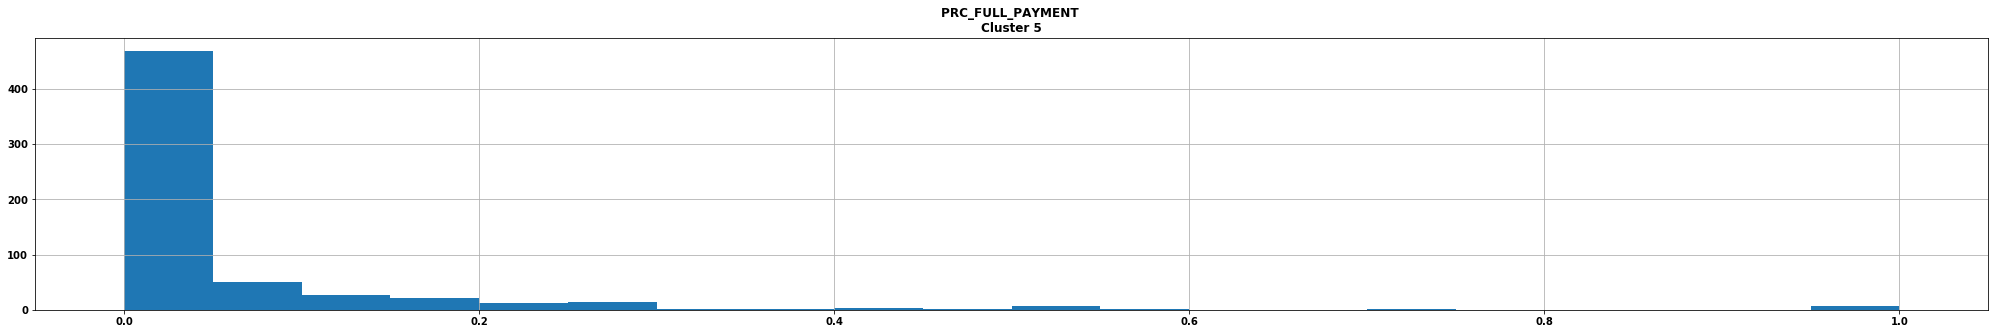

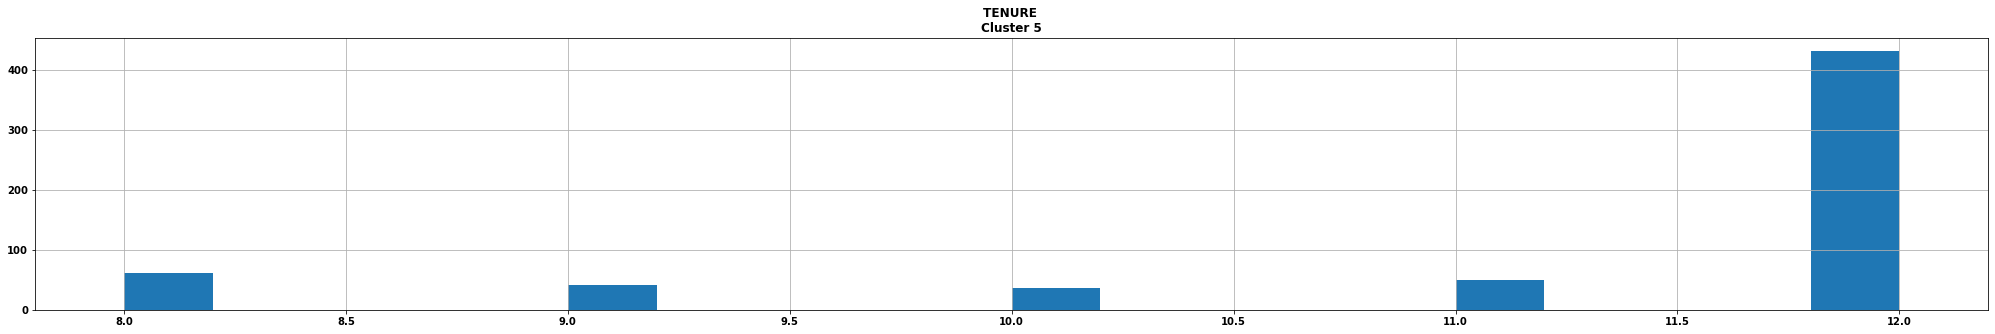

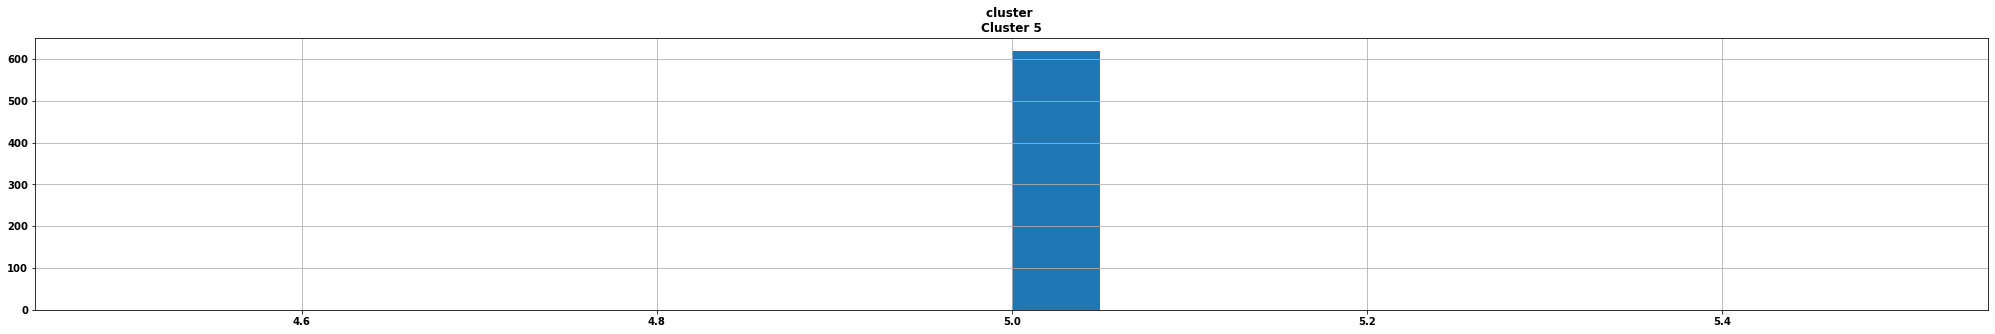

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.0
mean,3059.924074,0.893887,400.337593,272.047706,128.345977,3366.210388,0.246912,0.127597,0.135935,0.355068,9.358643,5.276252,5586.113967,2514.017189,1219.091705,0.052659,11.210016,5.0
std,2122.082235,0.201899,590.458137,479.461392,313.179269,1688.204340,0.329014,0.211790,0.269638,0.175569,5.714114,8.395538,3030.121469,2234.950782,1138.611267,0.140246,1.365726,0.0
min,10.268192,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,14.242628,0.000000,8.000000,5.0
25%,1217.551317,0.888889,0.000000,0.000000,0.000000,2151.402493,0.000000,0.000000,0.000000,0.250000,5.000000,0.000000,3000.000000,932.754731,475.697933,0.000000,11.000000,5.0
50%,2593.115716,1.000000,69.800000,0.000000,0.000000,3365.390269,0.083333,0.000000,0.000000,0.333333,8.000000,1.000000,5500.000000,1682.814334,939.667646,0.000000,12.000000,5.0
75%,4773.501283,1.000000,587.920000,345.295000,58.330000,4471.324695,0.449494,0.166667,0.083333,0.500000,13.000000,7.000000,7500.000000,3537.619898,1544.881874,0.000000,12.000000,5.0
max,7776.436900,1.000000,2569.940000,2569.940000,2012.670000,7232.069823,1.000000,1.000000,1.000000,0.727273,23.000000,51.000000,15000.000000,10226.601760,7781.671432,1.000000,12.000000,5.0


In [23]:
data_labeled_df, stats_df= visualise_kMeans_results(dataset_original = marketing_data_nonScaled_labeled_df, 
                                                    labels_Clusters=labels_Clusters, 
                                                    optimum_cluster_number=optimum_cluster_number,
                                                    cluster_number=5,
                                                    plot_overall=False, 
                                                    plot_cluster=True)

stats_df

### Observation:

General Behaviour of Cluster 5 customers:
- These customers have a mean balance of ~USD3,000.
- These customers also have frequent changes to their balances and make purchases on products that is around ~USD400.
- The one-off purchases are typically around ~US270 and presents with a lower fequency of ~0.12.
- These customers also tend to pay off ~5% of the full payment monthly with this credit card.
- These customers are also very loyal with a tenure of around ~11 years with this bank.
- Interestingly, these customers presents with a very large sums of Cash Advance at around ~USD3,400.
- These customers can be seen to pay back the cash advances 35% of the time.
- On average these customers also have a high number of transactions performed with cash advance at around 9.35.

Overall, these are customers can be said to use credit cards as a loan and therefore a lucrative sector of interest for the bank.
